# Projet Python : reconnaissance de mélanomes 

Louise Blart & Jeanne Astier

## Introduction 

Les grains de beauté, ou *nævus mélanocytaire*, sont des tâches présentes sur la peau. La plupart des grains de beauté sont bénins ; mais certains peuvent évoluer en tumeurs malignes, dans 10 cas pour 100 000 environ. Ils s'agit alors de __mélanomes__, une forme de cancer de la peau.

Comme pour toutes les formes de cancer, un diagnostic précoce augmente l'efficacité du traitement : un mélanome détecté tôt peut être traité facilement, avant que la maladie n'évolue vers une forme mortelle. 

Un "grain de beauté" nouveau ou ancien qui grandit rapidement, qui gratte, saigne, change de couleur doit alerter et nécessite une consultation dermatologique.Pour repérer précocement un mélanome, il est recommandé d'appliquer la règle ABCDE :
- **A** pour Asymétrie : la moitié du naevus ne colle pas avec l'autre moitié.
- **B** pour Bords irréguliers : les bords peuvent être encochés, mal délimités.
- **C** pour Couleur inhomogène variant d'une zone à l'autre de la lésion.
- **D** pour Diamètre, souvent supérieur à 6 mm.
- **E** pour Évolution : l’aspect de la lésion dans sa taille, sa forme, ou sa couleur a changé.


### Problématique

Comment la data science peut-elle aider à la reconnaissance des mélanomes ? 

Ce projet a vocation à __aider au diagnostic de mélanomes__ : nous voulons détecter, parmi un ensemble grains de beauté, lesquels sont malins et présentent un danger pour le patient. Pour ce faire, nous construisons sur algorithme de classification d'images distingant les grains de beauté "malins" et "bénins". 

NB : cette problématique a constitué l'objet d'un [challenge sur la plateforme Kaggle](https://www.kaggle.com/c/siim-isic-melanoma-classification), auquel ont participé plus de 3 000 équipes. Dans la mesure où nous sommes débutantes en machine learning, notre objectif n'est absolument pas de rivaliser avec tous ces participants : nous ne saurions prétendre concurrencer les gagnants d'un tel challenge en termes d'efficacité du diagnostic. Notre approche serait pluôt : comment, en partant de zéro en machine learning, peut-on essayer de traiter des images médicales pour y poser un diagnotic ?

### Plan

Notre projet se décompose en trois parties :
1. [Récupération et traitement des données](#1.-Récupération-et-traitement-des-données)
2. [Analyse de la base](#2.-Analyse-de-la-base)
3. [Modélisation et diagnostic](#3.-Modélisation-et-diagnostic)


### Préalable : téléchargement des modules

In [1]:
# Indiquez ici le chemin vers le dossier où se trouvent les modules téléchargés sur Github
# ATTENTION : ce path doit être le plus court possible (par exemple, directement sur le bureau de l'ordinateur) 
# pour éviter les erreurs
path_files_modules = r"C:\Users\jeann\Desktop\GIT"

In [2]:
# modules classiques 
import numpy as np
import pandas as pd
import csv
import os 
import random
import sys

# modules créés pour ce projet 
sys.path.insert(0, path_files_modules)
import Recuperation_des_donnees as RD

# pour télécharger les données
import urllib.request
from zipfile import ZipFile

# pour la visualisation des données
import matplotlib.pyplot as plt

# modules de traitement d'images
import cv2  # Utiliser pip install opencv-python et redemarrer le noyau si besoin
import PIL

# modules de traitement du format DICOM
import pydicom as dicom  # Utiliser pip install pydicom et redemarrer le noyau si besoin
import pydicom.data
from pydicom.pixel_data_handlers.util import convert_color_space 

## 1. Récupération et traitement des données

Nous avons choisi d'effectuer ce projet sur le thème de la reconnaissance de mélanomes pour deux raisons : 
- il s'agit d'une forme de reconnaissance d'images médicales relativement accessible (plus accessible que le traitement d'images médicales comme des scanners ou des IRM par exemple) ;
- une large base d'images de grains de beauté est mise à disposition librement par la SIIM (*Society for Imaging Informatics in Medicine*) et l'ISIC (*International Skin Imaging Collaboration*). 

Le premier enjeu, et pas des moindres, est donc la récupération de ces données et leur traitement pour pouvoir ensuite les exploiter. 

### a) téléchargement des données

Les données sont disponibles [sur le site de l'ISIC](https://challenge2020.isic-archive.com/). Il s'agit de photos de grains de beauté, chacune étant accompagnée de métadonnées (âge et sexe du patient, partie du corps concerncée, etc.). Ces données sont disponibles sous plusieurs formats : 
- au format DICOM (*Digital Imaging and Communications in Medecine*) : il s'agit d'un format standard international pour la gestion informatique des données issues de l'imagerie medicale. Chaque fichier .dcm comprend une image et les métadonnées s'y rapportant. 
- aux formats JPG (pour les images) et CSV (pour les métadonnées) : ces formats sont également proposés par l'ISIC car plus facilement utilisables par le grand public. 

Nous avons fait le choix d'__utiliser des données au format DICOM__ et de les retraiter nous-mêmes pour les adapter à nos besoins. Nous souhaitons en effet inscrire ce projet dans une perspective médicale, en utilisant donc les données telles qu'elles se présentent en imagerie médicale.  


Création d'un dossier Projet_Melanomes :

In [3]:
RD.Premiere_fonction ()

 Répondez par 1 pour 'Oui' et 0 pour 'Non' à ce questionnaire 
Avez vous déja lancé ce programme ? (le dossier "Projet_Melanomes" (contenant le fichier Base_complete (ISIC_2020_Training_Dicom dezippé), les dossiers Dicom_Sample_Test, Dicom_sample_Train, le fichier Diagnostic...) est-il deja créé ?) [1 :"oui", 0: "non"] 1
Insérez le chemin du document 'Projet_Melanomes' (exemple : C:/Users/louis/OneDrive/Bureau/Projet_Melanomes) : D:/Projet_Melanomes


A la fin de cette fonction, vous devez avoir : 
- Le dossier **" Projet_Melanomes"** contenant : 
    - le dossier **"ISIC_2020_Training_Dicom"** (fichier zip téléchargé depuis [le site du challenge](https://challenge2020.isic-archive.com/))
    - le dossier **"Base_complete"** ( extraction du fichier ISIC_2020_Training_Dicom) contenant : 
        - le dossier "train" contenant : 
            - les images au format dicom 
    - le dossier **"Dicom_Sample_Test"**, pour le moment vide, il contiendra les images au format **dicom** de notre base de **test** 
    - le dossier **"Dicom_Sample_Train"**, pour le moment vide, il contiendra les images au format **dicom** de notre base de **train**
    - le dossier **"JPG_Sample_Test"**, pour le moment vide, il contiendra les images au format **jpeg** de notre base de **test**
    - le dossier **"JPG_Sample_Test_Resize"**, pour le moment vide, il contiendra les images **réduites** et au format **jpeg** de notre base **test**
    - le dossier **"JPG_Sample_Train"**, pour le moment vide il contiendra des images au format **jpeg** de notre base **train** 
    -  le dossier **"JPG_Sample_Train_Resize"**, pour le moment vide, il contiendra les images **réduites** au format **jpeg** de notre base **train** 
    - le fichier .csv **"Diagnostic"** téléchargé à partir [du site du challenge](https://challenge2020.isic-archive.com/), rapportant le diagnostic des patients (mélin ou malin) 
    
    
Au cours de ce rapport, nous allons ajouter dans le dossier  **" Projet_Melanomes"**  :
- le fichier **"Base_complete"** au format .csv;  dataframe contenant l'ensemble de nos métadonnées 
- le fichier **"Sample"** au format .csv; dataframe contenant l'ensemble des métadonnées de l'échantillon selectionné

In [4]:
# Chemin vers le dossier Projet_Melanomes créé à partir de la fonction ci-dessus
Path_Projet_Melanomes= RD.Path_Projet_Melanomes

Le téléchargement depuis [le Drive](https://drive.google.com/drive/folders/1ByHZayDJD6OiB7g9D3hHsUMFWFZmeBy3?fbclid=IwAR02z7QWQKbkog22Rr8r-Bf-wSxKbe_YA07OvRohgDrLq69Y7eE8_UYx8xE) vous a été proposé dans la Premiere_fonction afin de limiter le temps de traitement et de téléchargement. Cette approche est entièrement factultative, et permet seulement de diminuer les temps d'attente. Ce projet est entièrement réalisable sans ce Drive.
On rappelle que ce Drive est non exhaustif et qu'il ne permet pas la parfaite réalisation de l'ensemble des cellules de ce rapport.

Rappel sur les fichiers du Drive : 
- Dossier Base_complete : contient seulement 15 des 33 126 images
- Base_complete.csv : exactement le fichier créé et utilisé dans ce rapport 
- Dossier JPG_Sample_Train : exactement le dossier créé et utilisé dans ce rapport
- Dossier JPG_Sample_Test : exactement le dossier créé et utilisé dans ce rapport

Si vous utilisez le Drive, merci de télécharger les fichiers ci-dessus en temps voulu et de les insérer dans le fichier Projet_Mélanomes créé à l'aide de la commande RD.Premiere_fonction ()

Si vous téléchargez les documents et dossiers via le Drive, il vous sera indiqué les cellules à ne pas lancer. Dans le cas contraire ( execution ordinaire et complete du projet), toutes les cellules sont à effectuer. 

### b) traitement des données

Maintenant que nous avons téléchargé toutes les données, nous pouvons commencer à les explorer - en particulier regarder comment se présente le format DICOM (format des images). 

In [5]:
# on choisit un fichier DICOM au hasard pour regarder sa structure 
path_dicom = Path_Projet_Melanomes+'/Base_complete/train'
files = os.listdir(path_dicom)
i = random.randint(0, len(files))
file = files[i]

In [6]:
# affichage des métadonnées associées à l'image
filename = pydicom.data.data_manager.get_files(path_dicom, file)[0]
ds = pydicom.dcmread(filename)
print(ds) 

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 220
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.7222.1843.1589860171957.1.1.0.0.0
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: "1.2.840.10008.5.1.4.1.1.77.1.4"
(0008, 0018) SOP Instance UID                    UI: 

On constate que les métadonnées sont très nombreuses ; mais seules quelques-unes nous intéressent : 

In [7]:
print("image :", file)
print("nom du patient :", ds.PatientName)
print("âge du patient :", ds.PatientAge)
print("sexe du patient :", ds.PatientSex)
print("prtie du corps : ", ds.BodyPartExamined)

image : ISIC_1106702.dcm
nom du patient : "ISIC^1106702"
âge du patient : 065Y
sexe du patient : M
prtie du corps :  TORSO


On peut enfin afficher l'image en tant que telle : 

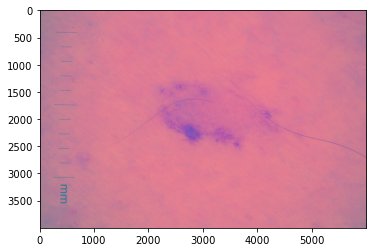

In [8]:
plt.imshow(ds.pixel_array) 

On constate que les couleurs de l'image n'ont pas l'air naturelles : il faut changer leur format de couleur pour avoir une aperçu des couleurs "naturelles" (format RGB). 
        

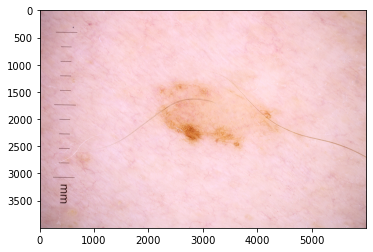

In [9]:
initial_color = ds.PhotometricInterpretation
convert = convert_color_space(ds.pixel_array, initial_color, 'RGB')
plt.imshow(convert)

Comme nous venons de le voir, le format DICOM peut être manipulé sur python à l'aide du module "pydicom". Cependant, ce format ne nous apparaît pas comme le plus facilement manipulable : nous préférons donc convertir ces données dans un format avec lequel nous sommes plus à l'aise. 

Deux étapes dans le traitement des données : 
- l'extraction des métadonnées de chaque fichier DICOM, pour les insérer dans un dataframe. 
- l'extraction des images de chaque fichier DICOM, pour les enregistrer au format JPG. 

Pour ce faire, nous avons créé une classe Dataframe dans le module Recuperation_des_donnees nous permettant d'extraire les métadonnées et de changer le format des images.

In [10]:
help(RD.Dataframe)

Help on class Dataframe in module Recuperation_des_donnees:

class Dataframe(builtins.object)
 |  Cette classe regroupe 3 fonctions : 
 |      - from_DICOM_to_DF : remplit un dataframe à partir des metadonnées DICOM
 |      - convert_DICOM_to_JPG : convertit une image DICOM en JPG
 |      - convert_to_JPG_RGB : convertit une image DICOM en JPG avec comme espace de couleurs le format RGB
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  convert_DICOM_to_JPG(self)
 |      Cette fonction permet de convertir un dossier dont les images sont sous
 |      le format DICOM en format JPG
 |      
 |      Cette fonction :
 |          - prend en parametres "self" permettant d'aller chercher les informations 
 |          dans la partie init
 |          - renvoie : Le dossier ou les images.jpg sont enregistrees  
 |          
 |      Exemple : 
 |          w = Dataframe()
 |          w.convert_DICOM_to_JPG()
 |  
 |

In [11]:
w=RD.Dataframe()
# Mise à jour de notre classe en fonction de nos chemins d'accès 
w.path_base_complete = Path_Projet_Melanomes+'/Base_complete/train'
w.path_Diagnostic= Path_Projet_Melanomes+'/Diagnostic.csv'

Nous traitons maintenant l'ensemble des fichiers DICOM téléchargés pour les insérer dans le dataframe des métadonnées. 

( __/!\ attention__ : là encore, la cellule suivant peut prendre plusieurs heures à tourner. Le programe doit en effet passer en revue quelques 33 106 fichiers pour en extraire des données, ce qui peut être un peu long).

Afin de limiter le temps de chargement, vous pouvez trouver ce fichier directement au format .csv sur le [drive](https://drive.google.com/drive/folders/1ByHZayDJD6OiB7g9D3hHsUMFWFZmeBy3?usp=sharing). Merci de l'enregistrer sous le nom **"Base_complete"** (format .csv) dans le dossier **"Projet_Melanomes"**. 

Les deux prochaines cellules ne sont pas à faire tourner dans le cas d'un téléchargement sur le Drive.

In [148]:
# Cellule non conseillée si téléchargement via le Drive 
df = w.from_DICOM_to_DF()

le fichier est pret !


Comme cette étape de création et de remplissage du dataframe complet est très longue, nous préférons éviter de devoir la relancer à chaque nouvelle ouverture du projet ; aussi enregistrons-nous ce dataframe au format csv, pour pouvoir ensuite l'ouvrir plus facilement et rapidement. 

In [26]:
# Cellule non conseillée si téléchargement via le Drive 
df.to_csv(Path_Projet_Melanomes+'/Base_complete.csv', index = False)

## 2. Analyse de la base

Nous allons maintenant analyser la base ainsi construite, et la représenter sous forme de graphiques pour se familiariser avec les données. 

Au préalable, nous téléchargeons les modules nécessaires :


In [12]:
#visualisation
import seaborn as sns

#Tests statistiques 
import scipy.stats as stats

Nous rechargons la base à partir du CSV précédemment enregistré ( ou téléchargé depuis le Drive), pour éviter de devoir relancer le téléchargement de la base à chaque fois. 

In [5]:
df=pd.read_csv(Path_Projet_Melanomes+'/Base_complete.csv')
df.head()

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
0,ISIC_0015719,40,F,UPPER EXTREMITY,ISIC_0015719,0,IP_3075186
1,ISIC_0052212,50,F,LOWER EXTREMITY,ISIC_0052212,0,IP_2842074
2,ISIC_0068279,45,F,HEAD/NECK,ISIC_0068279,0,IP_6890425
3,ISIC_0074268,55,F,UPPER EXTREMITY,ISIC_0074268,0,IP_8723313
4,ISIC_0074311,40,F,LOWER EXTREMITY,ISIC_0074311,0,IP_2950485


In [6]:
df.shape

(33126, 7)

On remarque que cette base est volumineuse : 33 126 lignes, c'est-à-dire 33 126 images de mélanomes (le nombre de patients peut être moindre : un même patient peut avoir plusieurs images de ménalomes). 

Cette base de données est-elle représentative de l'ensemble de la population concernant les mélanomes ? 

Nous commençons à analyser la base pour se familiariser avec son contenu et ses caractéristiques. 

In [7]:
df.isnull().sum()

image_id        0
patient_age     0
patient_sex    65
body_part       0
image_name      0
target          0
patient_id      0
dtype: int64

Cette commande permet d'identifier le nombre de valeurs manques. Il n'y en a ici que très peu : seulement 65 patients sur 33 126 ont omis de renseigner leur genre (valeur 'nan') et 49 patients ont renseigné 'X'. 
Les valeurs non-exploitables de la variable 'Patient_sex' représentent moins de 0,3% de notre échantillon, nous ne ferons donc pas d'étude sur les non réponses, et retirons ces patients de notre base de données. 


In [16]:
indexNames = df[ df['patient_sex']=='X'].index
df.drop(indexNames , inplace=True)
df.dropna(inplace=True)
# Enregistrement sur notre fichier.csv
df.to_csv(Path_Projet_Melanomes+'/Base_complete.csv', index = False)

### 1 - Analyses univariées

#### a) L'âge

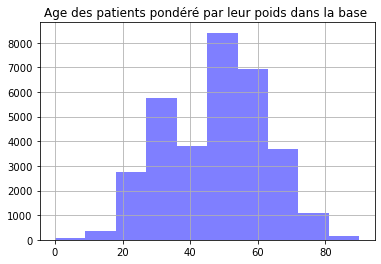

Moyenne : 46.87795347146492 
 Ecart type: 14.507820283196496


In [17]:
df['patient_age'].hist( facecolor='b', alpha=0.5)
plt.title('Age des patients pondéré par leur poids dans la base ')
plt.show()
print('Moyenne :', df['patient_age'].mean(), '\n', 'Ecart type:',  df['patient_age'].std())

L'âge moyen est donc de 46,9 ans ; attention cependant, il ne s'agit pas d'une moyenne simple de l'âge des patients, mais de l'âge moyen des patients pondéré par leur poids dans la base (i.e. par le nombre d'images d'un même patient, chaque patient ayant plusieurs images comme nous le verrons plus loin). 


<AxesSubplot:title={'center':'Age des patients'}, xlabel='patient_age'>

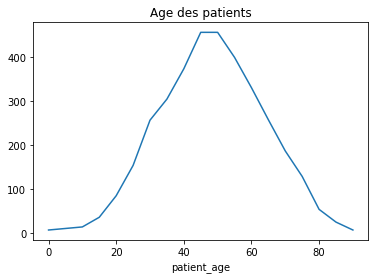

In [20]:
df1 = df.groupby('patient_age')["patient_id"].nunique()
plt.title('Age des patients')
df1.plot()

Ce graphique illustre cette fois la répartition de l'âge parmi la population des patients (et non plus des images) : la distribution est plus proche d'une loi normale, avec une moyenne aux alentours de 50ans. 

#### b) Le sexe

Text(0.5, 0, ' Parité Hommes/Femmes')

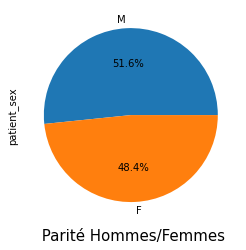

In [44]:
df["patient_sex"].value_counts().plot(kind='pie' , autopct='%1.1f%%')
plt.xlabel(' Parité Hommes/Femmes', fontsize=15)

In [45]:
# parmi les images
df.groupby('patient_sex')['image_id'].nunique()

patient_sex
F    15969
M    17043
Name: image_id, dtype: int64

In [46]:
# parmi les patients
df.groupby('patient_sex')['patient_id'].nunique()

patient_sex
F     976
M    1075
Name: patient_id, dtype: int64

La parité Homme/Femme est (presque) respectée parmi les images comme parmi les patients - les hommes étant en très légère majorité dans les deux cas. 

#### c) La partie du corps

In [35]:
df['body_part'].value_counts()

TORSO              16803
LOWER EXTREMITY     8382
UPPER EXTREMITY     4958
HEAD/NECK           1843
SKIN                 527
PALMS/SOLES          375
ORAL/GENITAL         124
Name: body_part, dtype: int64

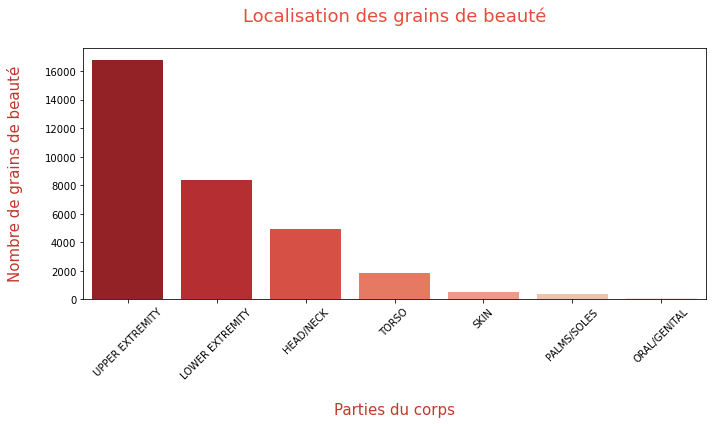

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(x=df['body_part'].unique(), y=df['body_part'].value_counts(), palette="Reds_r")
plt.xlabel('\nParties du corps', fontsize=15, color='#c0392b')
plt.ylabel("Nombre de grains de beauté\n", fontsize=15, color='#c0392b')
plt.title("Localisation des grains de beauté\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

#### d) Melanomes bénins et malins

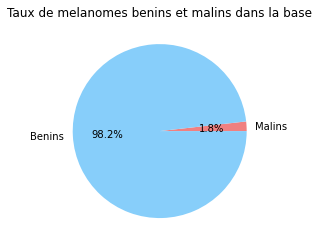

In [38]:
plt.pie([sum(df['target']==1),sum(df['target']==0)], labels = ['Malins','Benins'],colors = ['lightcoral','lightskyblue'],autopct='%1.1f%%')
plt.title("Taux de melanomes benins et malins dans la base")
plt.show()

Le taux de malignité parmi les grains de beauté est donc très faible : 1,8%. Ce taux est néanmoins élevé par rapport à la population générale. Cependant, il est plus facile de comparer notre base à l'ensemble de la population sur le taux de malignité rapporté au nombre de personnes plutôt qu'au nombre de grains de beauté : c'est ce que nous faisons dans la section suivante. 

#### e) Patients

In [39]:
print("nombre d'images :", df["image_id"].nunique())
print("nombre de patients :", df["patient_id"].nunique())

nombre d'images : 33012
nombre de patients : 2051


Il y a bien moins de patients que d'images (33 012 images pour 2 051 patients) : plusieurs images peuvent donc appartenir à un même patient (environ 16 images par patient en moyenne)

Text(0.5, 1.0, "nombre de mélanomes bénins et d'images pour les 20 patients ayant le plus de mélanomes bénins")

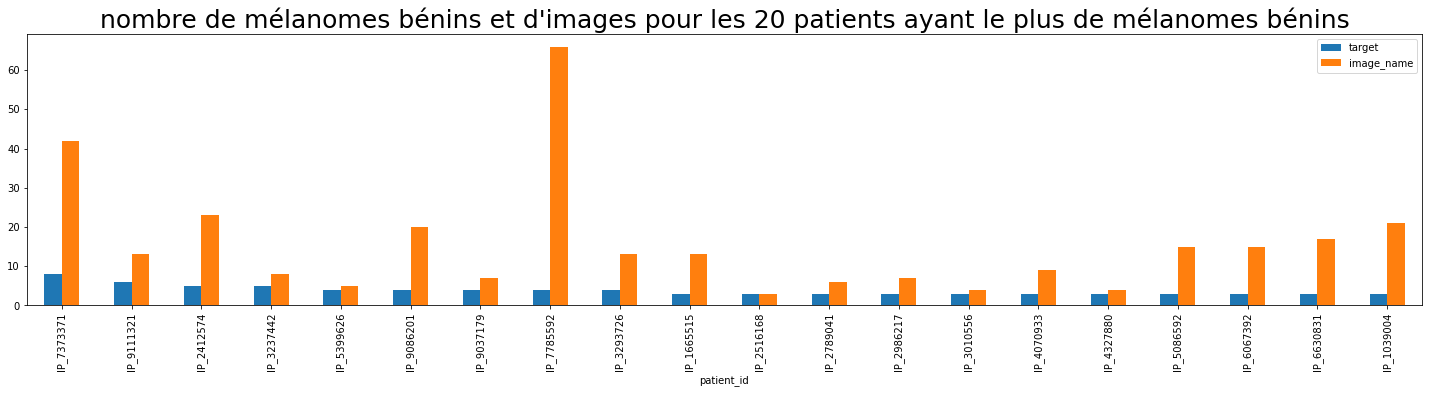

In [40]:
df1 = df.groupby("patient_id").sum()["target"]
df2 = df.groupby("patient_id").count()["image_name"]

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "image_name", ascending = False).head(150)

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "target", ascending = False).head(150)

pd.concat([df1, df2], axis=1, sort=False).sort_values(by = "target", ascending = False).head(20).plot(kind = "bar", figsize = (25,5))
plt.title("nombre de mélanomes bénins et d'images pour les 20 patients ayant le plus de mélanomes bénins", fontsize = 25)

Il y a jusqu'à 115 images par patient, et jusqu'à 8 mélanomes par patient au sein de la base de donnée. Mais les patients qui ont le plus d'images ne sont pas nécessairement ceux qui ont le plus de mélanomes.

In [50]:
df1 = df.groupby("patient_id").agg({"target" : "sum"})
print("nombre moyen de mélanomes par patient :", np.average(df1["target"]))

nombre moyen de mélanomes par patient : 0.28473915163334956


Le nombre moyen de mélanomes par patient est surprenamment élevé : 0,28. Nous attentions un chiffre beaucoup plus bas du fait de la faible proportion du mélanomes parmi les images de la base (moins de 2%). Cela est en fait dû au faible nombre de patients au regard du nombre d'images. Si les ménalomes sont très dilués parmi les images, ils le sont beaucoup moins parmi les patients. 

In [51]:
print ("nombre de patients n'ayant aucun mélanomes :", len(df1[df1["target"] == 0]))
print ("nombre de patients ayant au moins un mélanome :", len(df1[df1["target"] > 0]))
print("proportion de patients ayant au moins un mélanome :", len(df1[df1["target"] > 0]) / df["patient_id"].nunique() *100, "%")

nombre de patients n'ayant aucun mélanomes : 1623
nombre de patients ayant au moins un mélanome : 428
proportion de patients ayant au moins un mélanome : 20.867869332033155 %


Plus de 20% des patients de la base ont un mélanome : cette proportion est très très largement supérieure à la proportion de personnes touchées par un mélanome au sein de la population (le taux d'incidence des mélanomes étant d'environ 10 pour 100 000 en France). Cette différence s'explique par le fait que nous disposons d'un échantillon de données médicales sur-représentant volontairement les cas malins, pour apprendre à les diagnostiquer. 

In [52]:
print("nombre moyen de mélanomes parmi les patients en ayant au moins un :", np.average(df1[df1["target"] > 0]["target"]))
print("nombre de patients ayant plusieurs mélanomes :", len(df1[df1["target"] > 1]))
print("proportion de patients ayant plusieurs mélanomes parmi les patients malades :", len(df1[df1["target"] > 1]) / len(df1[df1["target"] > 0])*100, "%")

nombre moyen de mélanomes parmi les patients en ayant au moins un : 1.3644859813084111
nombre de patients ayant plusieurs mélanomes : 109
proportion de patients ayant plusieurs mélanomes parmi les patients malades : 25.46728971962617 %


Parmi les patients malades (i.e. ayant au moins un mélanome), plus d'un quart présente plusieurs mélanomes (jusqu'à 8, comme vu plus haut). Les mélanomes, en faible nombre dans la base au regard du nombre d'image, sont donc en fait concentrés sur une relativement petite part des patients, la majorité n'ayant que des grains de beauté bénins.

### 2 - Analyses bivariées

#### a) Les mélanomes et l'âge

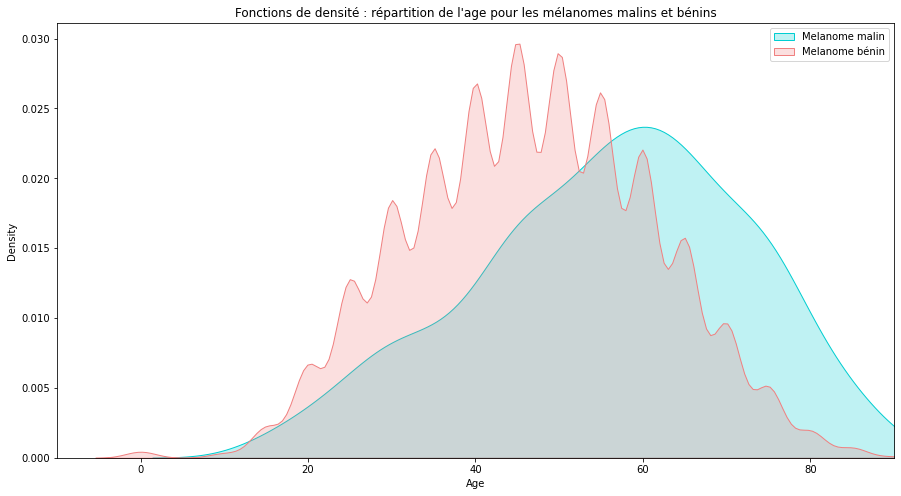

In [133]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["patient_age"][df.target == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["patient_age"][df.target == 0], color="lightcoral", shade=True)
plt.legend(['Melanome malin', 'Melanome bénin'])
plt.title("Fonctions de densité : répartition de l'age pour les mélanomes malins et bénins")
ax.set(xlabel='Age')
plt.xlim(-10,90)
plt.show()

La distribution des mélanomes malins est décalée sur la droite par rapport à celle des bénins. Cela signifie que les personnes agées sont plus touchées par les mélanomes malins que les personnes jeunes. Les articles scientifiques confirment cette hypothèse. 


#### b) Melanomes et sexe

In [134]:
(df.groupby('patient_sex')['target'].sum() / df.groupby('patient_sex')['patient_id'].count() *100)

patient_sex
F    1.377669
M    2.135774
dtype: float64

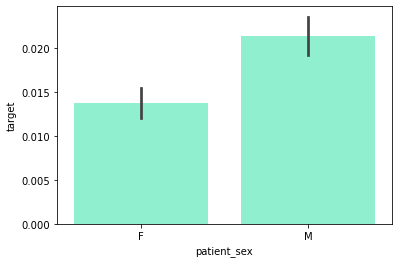

In [135]:
sns.barplot(x='patient_sex', y='target', data=df, color="aquamarine")
plt.show()

D'après cet échantillon les hommes sont plus touchés par les mélanomes malins que les femmes. 
1,37% des femmes de l'échantillon sont porteuses d'un mélanome bénins contre 2,13% des hommes.
Les articles scientifiques ne confirment pas cette hypothèse. 


In [136]:
print(stats.ttest_ind(df["target"][df.patient_sex == 'F'],df["target"][df.patient_sex == 'M']))

Ttest_indResult(statistic=-5.2236842264877605, pvalue=1.764609629122168e-07)


D'après les résultats du T-test, les populations féminines et masculines sont significativement différentes en ce qui concerne les mélanomes (p-value < 0,001)

#### c) Mélanomes et partie du corps

In [137]:
(df.groupby('body_part')['target'].sum() / df.groupby('body_part')['patient_id'].count() *100)

body_part
HEAD/NECK          4.015193
LOWER EXTREMITY    1.479361
ORAL/GENITAL       3.225806
PALMS/SOLES        1.333333
SKIN               1.707780
TORSO              1.529489
UPPER EXTREMITY    2.238806
dtype: float64

<AxesSubplot:xlabel='target', ylabel='body_part'>

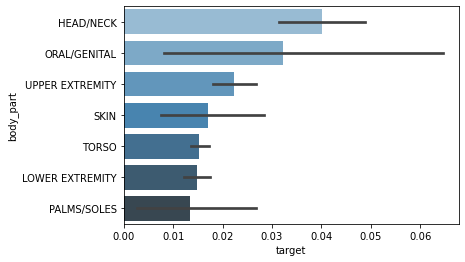

In [138]:
sns.barplot(x=df['target'], y=df['body_part'],palette='Blues_d', orient='h',  order=["HEAD/NECK", "ORAL/GENITAL","UPPER EXTREMITY","SKIN", "TORSO", "LOWER EXTREMITY", "PALMS/SOLES" ])

Le taux de mélanomes malins est plus élevé sur les parties du corps : 
- tête et cou
- orales et génitales 
- les membres supérieurs
      
Selon les articles scientifiques, les zones les plus exposées aux mélanomes malins sont les parties les plus exposées au soleil.
Il est donc raisonnable d'identifier la tête, le cou et les membres supérieurs dans les parties du corps les plus touchées par les mélanomes malins. 
Dans ce sens, cela est étonnant d'identifier les zones orales et génitales comme zones à risque. Cependant, dans notre échantillon, la catégorie "Oral/Genital" est la moins représentée des parties du corps; il n'y a que 124 images. Ce qui est très faible par rapport à notre base totale. L'échantillon est probablement peu représentatif de la population totale pour cette partie du corps.


In [139]:
print(stats.kruskal(df["target"][df.body_part == 'HEAD/NECK'],df["target"][df.body_part == 'ORAL/GENITAL'],df["target"][df.body_part == 'SKIN'],df["target"][df.body_part == "UPPER EXTREMITY"],df["target"][df.body_part == "TORSO"],df["target"][df.body_part == "PALMS/SOLES"],df["target"][df.body_part == "LOWER EXTREMITY"]))

KruskalResult(statistic=71.33319858858539, pvalue=2.1778447508295032e-13)


D'après le test de Kruskal Wallis les populations de mélanomes sont différentes en fonction des parties du corps. 

### 3 - Régression linéaire multiple

La régression linéaire multiple permet de créer des modéles permetant d'expliquer une variable Y à partir des variables explicatives X. Nous allons essayer d'expliquer la variable "target" (variable binaire indiquant la classe du grain de beauté : bénin [0] et malin [1] )  à partir de l'age du patient, son sexe et la partie du corps sur laquelle se trouve le grain de beauté.

In [8]:
training=pd.get_dummies(df, columns=["patient_sex","body_part"])

# On retire la variable patient_sex_F, qui est parfaitement colinéaire à patient_sex_M
training.drop('patient_sex_F', axis=1, inplace=True) 
final_train = training
final_train.head()

,image_id,patient_age,image_name,target,patient_id,patient_sex_M,patient_sex_X,body_part_HEAD/NECK,body_part_LOWER EXTREMITY,body_part_ORAL/GENITAL,body_part_PALMS/SOLES,body_part_SKIN,body_part_TORSO,body_part_UPPER EXTREMITY
0,ISIC_0015719,40,ISIC_0015719,0,IP_3075186,0,0,0,0,0,0,0,0,1
1,ISIC_0052212,50,ISIC_0052212,0,IP_2842074,0,0,0,1,0,0,0,0,0
2,ISIC_0068279,45,ISIC_0068279,0,IP_6890425,0,0,1,0,0,0,0,0,0
3,ISIC_0074268,55,ISIC_0074268,0,IP_8723313,0,0,0,0,0,0,0,0,1
4,ISIC_0074311,40,ISIC_0074311,0,IP_2950485,0,0,0,1,0,0,0,0,0


In [9]:
import statsmodels.api as sm
from sklearn import linear_model

In [10]:
X = final_train[["patient_age", "patient_sex_M", "body_part_HEAD/NECK", "body_part_LOWER EXTREMITY", 
              "body_part_ORAL/GENITAL","body_part_PALMS/SOLES","body_part_SKIN", "body_part_TORSO", "body_part_UPPER EXTREMITY"]]
X = sm.add_constant(X) # une autre façons d'ajouter une constante
y = final_train["target"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     39.45
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           4.02e-63
Time:                        18:54:57   Log-Likelihood:                 20332.
No. Observations:               33126   AIC:                        -4.065e+04
Df Residuals:                   33117   BIC:                        -4.057e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

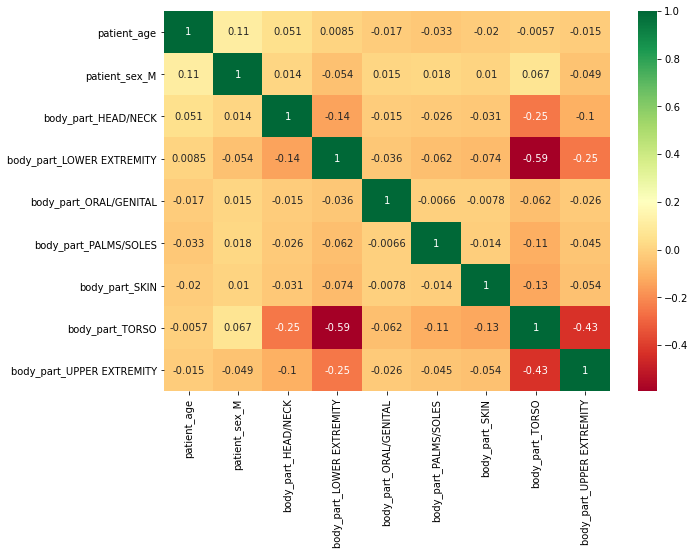

In [13]:
Selected_features = ["patient_age", "patient_sex_M", "body_part_HEAD/NECK", "body_part_LOWER EXTREMITY", 
              "body_part_ORAL/GENITAL","body_part_PALMS/SOLES","body_part_SKIN", "body_part_TORSO", "body_part_UPPER EXTREMITY"]
X = final_train[Selected_features]

plt.subplots(figsize=(10, 7))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

Notre modéle n'est pas convainquant, les coefficients sont très faibles (ils n'ont donc pas de significativité pratique), les variables age, parties du corps et sexe expliquent à hauteur de 0,9% les mélanomes (R²=0,009).
Il n'est pas possible d'expliquer convenablement les mélanomes à partir de ces variables explicatives.
Il est donc primordial d'utiliser une autre méthode afin de fournir un modèle prédictif acceptable. 


### 4 - Régression logistique

La régression logistique est une technique prédictive. Elle vise à construire un modèle permettant de prédire / expliquer les valeurs prises par une variable cible qualitative (le plus souvent binaire, on parle alors de régression logistique binaire) à partir d’un ensemble de variables explicatives quantitatives ou qualitatives (un codage est nécessaire dans ce cas).
Nous voulons ici expliquer la variable 'target' (binaire) en fonction des variables 'patient_age'(quantitative), 'patient_sex'(qualitative), 'body_part'(qualitative) par une régression logistique


In [14]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [15]:
# On divise la base en deux : 80% dans la base de training et 20% dans la base test. 
X_app,X_test,y_app,y_test = model_selection.train_test_split(X,y,test_size = 6500,random_state=0) # 

In [16]:
lr = LogisticRegression(solver="liblinear")
# Construction du modéle predictif :  
modele = lr.fit(X_app,y_app)

#Prediction sur l'échantillon test
y_pred = modele.predict(X_test)

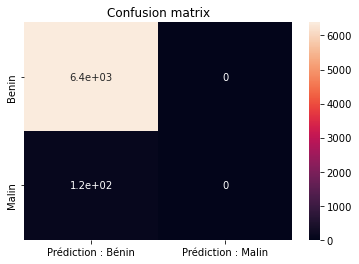

In [17]:
#matrice de confusion : confrontation entre les Y observés sur l’échantillon test et la prédiction

cm = metrics.confusion_matrix(y_test, y_pred)

ax = plt.axes()

sns.heatmap(cm, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=('Prédiction : Bénin', 'Prédiction : Malin'), 
           yticklabels= ('Benin', 'Malin'), ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [148]:
acc = metrics.accuracy_score(y_test,y_pred)
print('Le taux de succés est de ',acc *100,'%')

Le taux de succés est de  98.1076923076923 %


On pourrait croire que ce modéle de classification est efficace ( il a un taux de succés de 98%). Cependant, cela est dû à la proportion de bénins et de malins de notre base. En effet, le taux de malins est très faible ( moins de 2%), notre modéle, en prédisant toujours bénin, arrive donc à limiter ses erreurs. Ce modéle n'est pas satisfaisant pour différencier les mélanomes des grains de beauté. Il apparait primordial d'utiliser les images afin de rendre une prédiction acceptable.

## 3. Modélisation et diagnostic


In [47]:
# Modules créés pour ce projet 
import Echantillonnage
import Visualisation

# package machine learning
import sklearn 

import shutil 
import pydicom
import seaborn as sns
from tqdm import tqdm
import gc
import sklearn.metrics

Using TensorFlow backend.


### 1 - Création des bases train et test

On veut constituer une base d'entraînement (train) et une base de test à partir de l'ensemble des images (plus de 33 000). 
Cette base de donnée est représentée par le Dataframe "df" importé précedemment. 

In [154]:
df=pd.read_csv(Path_Projet_Melanomes+'/Base_complete.csv')
df.head()

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
0,ISIC_0015719,40,F,UPPER EXTREMITY,ISIC_0015719,0,IP_3075186
1,ISIC_0052212,50,F,LOWER EXTREMITY,ISIC_0052212,0,IP_2842074
2,ISIC_0068279,45,F,HEAD/NECK,ISIC_0068279,0,IP_6890425
3,ISIC_0074268,55,F,UPPER EXTREMITY,ISIC_0074268,0,IP_8723313
4,ISIC_0074311,40,F,LOWER EXTREMITY,ISIC_0074311,0,IP_2950485


Calcul du taux de mélanomes au sein de cette base :

In [155]:
t = sum(df['target']==1) / len(df.index)
print("taux de malignité des mélanomes :", t*100, "%")

taux de malignité des mélanomes : 1.769053677450624 %


Comme nous l'avions déjà vu, le taux de malignité des mélanomes est très faible (1,76%).

Aussi, dans un premier temps, pour faciliter la construction de premiers modèles, nous construisons une base réduite avec un taux de malignité supérieur. Nous réduisons ainsi le nombre total d'images, ce qui nous permettra aussi de construire des modèles plus économes en mémoire vive. C'est à partir de cette base réduite que nous constitueront les bases test et train. 

#### a) échantillonnage 

Pour ce faire, on commence par définir une fonction d'échantillonnage simple dans notre module Echantillonnage : 

In [156]:
help(Echantillonnage.simple_sampling)

Help on function simple_sampling in module Echantillonnage:

simple_sampling(df, size, malignancy_rate)
    Cette fonction crée un échantillon simple de taille fixée avec un taux de malignité fixé à partir d'un dataframe. 
    Les lignes sélectionnées dans l'échantillon sont tirées aléatoirement, de manière équiprobable. 
        
        Cette fonction :
            - prend en paramètres :
                - df : le dataframe à partir duquel on souhaite construire l'échantillon
                - size : la taille de l'échantillon   
                - malignancy_rate : le taux d'images représentant des grains de beauté malins au sein de l'échantillon
            - renvoie : l'échantillon ainsi construit
            
        Exemple : 
            df = df
            size = 100
            malignancy_rate = 0,2
            => renvoie un dataframe de 100 lignes sélectionnées aléatoirement dans df dont 20% représentent des 
            mélanomes (malins), 80% des grains de beauté bénins.



Dans un premier temps, nous choisissons d'extraire un échantillon de 1 000 images dont 50% représentent des grains de beauté malins (mélanomes) ; ces paramètres pourront être amenés à varier. 

In [157]:
np.random.seed(10)
size = 1000
malignancy_rate = 0.5
df_sample = Echantillonnage.simple_sampling(df, size, malignancy_rate)
df_sample.head()

,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
89,ISIC_0149568,55,F,UPPER EXTREMITY,ISIC_0149568,1,IP_0962375
233,ISIC_0188432,50,F,UPPER EXTREMITY,ISIC_0188432,1,IP_0135517
312,ISIC_0207268,55,M,TORSO,ISIC_0207268,1,IP_7735373
396,ISIC_0232101,60,M,TORSO,ISIC_0232101,1,IP_8349964
472,ISIC_0250839,75,M,HEAD/NECK,ISIC_0250839,1,IP_6234053


On sauvegarde l'échantillon ainsi construit dans un CSV (au cas où)

In [158]:
df_sample.to_csv(Path_Projet_Melanomes+'/Sample.csv')

#### b) train / test split

Pour diviser cet échantillon en train et test, on s'appuie sur le package scikit-learn. 

Pour l'instant, on choisit arbitrairement d'allouer 20% de notre échantillon au test et 80% au test.

In [49]:
from sklearn.model_selection import train_test_split

X = df_sample["image_id"]
Y = df_sample["target"]

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

### 2- Définition des classes et import des données

In [13]:
# définition des classes (deux seulement : bénin et malin)
class_names = ['benin', 'malin']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

In [14]:
class_names_label

{'benin': 0, 'malin': 1}

In [15]:
image_size = 150
# peut être modifié en adaptant les paramètres du CNN en conséquence

In [54]:
df_sample=pd.read_csv(Path_Projet_Melanomes+'/sample.csv')
df_sample.head()

,Unnamed: 0,Unnamed: 0.1,image_id,patient_age,patient_sex,body_part,image_name,target,patient_id
0,89,90,ISIC_0149568,55,F,UPPER EXTREMITY,ISIC_0149568,1,IP_0962375
1,233,234,ISIC_0188432,50,F,UPPER EXTREMITY,ISIC_0188432,1,IP_0135517
2,312,313,ISIC_0207268,55,M,TORSO,ISIC_0207268,1,IP_7735373
3,396,398,ISIC_0232101,60,M,TORSO,ISIC_0232101,1,IP_8349964
4,472,474,ISIC_0250839,75,M,HEAD/NECK,ISIC_0250839,1,IP_6234053


**/!\ Attention**, si vous utilisez le Drive, certaines des cellules suivantes ne sont pas à executer :

In [59]:
#Cellule non conseillée si téléchargement via le Drive 

#création d'un dossier avec les images DICOM de la base train
path_dicom_sample_train = Path_Projet_Melanomes+'/Dicom_Sample_Train'  

for file in X_train :
    shutil.copy(w.path_base_complete + '/' + file +'.dcm', path_dicom_sample_train + '/' + file +'.dcm')

In [60]:
#Cellule non conseillée si téléchargement via le Drive 


#création d'un dossier avec les images DICOM de la base test
path_dicom_sample_test =  Path_Projet_Melanomes+'/Dicom_Sample_Test' 

for file in X_test :
    shutil.copy(w.path_base_complete + '/' + file +'.dcm', path_dicom_sample_test + '/' + file +'.dcm')

In [61]:
#Cellule non conseillée si téléchargement via le Drive 

#conversion des images train en jpg - attention cette fonction est longue à exécuter (plusieurs dizaines de minutes)
w.path_base_complete = path_dicom_sample_train
w.path_jpg_RGB=Path_Projet_Melanomes+'/JPG_Sample_Train' 
w.convert_to_JPG_RGB()

Le dossier est pret !


In [62]:
#Cellule non conseillée si téléchargement via le Drive 

#conversion des images test en jpg - attention cette fonction est longue à exécuter (plusieurs dizaines de minutes)
w.path_base_complete = path_dicom_sample_test
w.path_jpg_RGB=Path_Projet_Melanomes+'/JPG_Sample_Test' 
w.convert_to_JPG_RGB()

Le dossier est pret !


**Si vous utilisez le Drive**, il est temps de télécharger les dossiers JPG_Sample_Train et JPG_Sample_Test (présents sur le Drive) dans le dossier Projet_Melanomes précedemment créé. 

Vous devriez alors avoir  : 
- Le dossier **" Projet_Melanomes"** contenant : 
    - le dossier **"ISIC_2020_Training_Dicom"** 
    - le dossier **"Base_complete"** :
        - le dossier "train" contenant : 
            - 15 images au format dicom 
    - le dossier **"Dicom_Sample_Test"** : vide
    - le dossier **"Dicom_Sample_Train"**: vide
    - le dossier **"JPG_Sample_Test"** : 200 images (téléchargées à partir du Drive)
    - le dossier **"JPG_Sample_Test_Resize"**, pour le moment vide
    - le dossier **"JPG_Sample_Train"**, 800 images (téléchargées à partir du Drive)
    -  le dossier **"JPG_Sample_Train_Resize"**, pour le moment vide
    - le fichier .csv **"Diagnostic"**
    - le fichier **"Base_complete"** au format .csv
    - le fichier **"Sample"** au format .csv

On redimensionne les images du dossier *Sample_Test* et *Sample_Train*, et on enregistre les images ainsi redimensionnées dans les dossiers *Sample_Test_Resize* et *Sample_Train_Resize* :


In [150]:
# Pour le dossier Train : (Quelques minutes)
w.path_jpg_RGB = Path_Projet_Melanomes+'/JPG_Sample_Train'
w.path_jpg_Resize = Path_Projet_Melanomes+'/JPG_Sample_Train_Resize'
w.redimensionner((image_size, image_size))

Le dossier est pret !


In [151]:
# Pour le dossier Test : (Quelques minutes)
w.path_jpg_RGB = Path_Projet_Melanomes+'/JPG_Sample_Test'
w.path_jpg_Resize = Path_Projet_Melanomes+'/JPG_Sample_Test_Resize'
w.redimensionner((image_size, image_size))

Le dossier est pret !


Une autre manière de rendre nos images moins complexes serait de les faire passer en nuance de gris. On diminuerait alors la complexité des images par trois. En effet une image en couleur à 3 canaux, alors qu'une image en noir et blanc n'en a qu'un, comme explicité dans les graphiques ci-dessous :

Trois canaux représentant les espaces de couleurs Rouge, Vert et Bleu


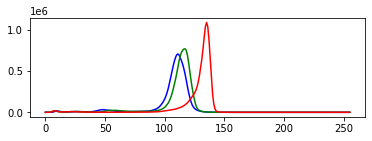

 Un seul canal pour les images en nuances de gris


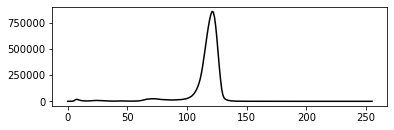

In [65]:
files = os.listdir(Path_Projet_Melanomes+'/JPG_Sample_Train') # Selectionne aléatoire d'une image du dossier JPG_Sample_Train
path_image_random = Path_Projet_Melanomes+'/JPG_Sample_Train'+'/'+files[random.randint(0, len(files))]

Visualisation.complexite_couleurs (path_image_random) # Pour plus d'explication sur cette fonction : help(Visualisation.complexite_couleurs)

Cependant, selon la régle des critéres ABCDE, la couleur (non homogène) est l'un des principaux indicateurs permettant l'identification d'un mélanome. C'est pourquoi, nous choisissons de garder nos images dans le format de couleur RGB. Nous gardons cependant à l'esprit que nos images sont de ce fait assez complexes. 

Il faut ensuite charger les données pour pourvoir les insérer dans le modèle (attention, cette cellule prend un peu de temps à être exécutée, de l'ordre de quelques minutes) :

In [55]:
path_jpg_train = Path_Projet_Melanomes+'/JPG_Sample_Train_Resize' 
path_jpg_test = Path_Projet_Melanomes+'/JPG_Sample_Test_Resize' 
    
meta_data = df_sample
meta_data = meta_data.set_index("image_id")
datasets = [path_jpg_train, path_jpg_test]

output = []

#itération sur chaque dataset (train puis test)
for dataset in datasets :

    files = os.listdir(dataset)
    images = np.zeros((len(files), image_size, image_size, 3), dtype=np.float32)
    labels = np.zeros(len(files))

    # itération sur chaque image du dataset
    for i, file in tqdm(enumerate(files)):
        
        # obtention du le chemin de l'image
        img_path = os.path.join(dataset, file)

        # obtention du label de l'image
        label = meta_data.loc[file[0:12]].target

        # ouverture de l'image et retraitement de l'image (changement de couleurs et réduction de taille)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))

        # ajout de l'image et de son label à la liste de résultats
        images[i, :] = (np.array(image) / 255).astype(np.float32)
        labels[i] = label

        gc.collect()

    output.append((images, labels))

800it [00:58, 13.77it/s]
200it [00:15, 13.21it/s]


on renomme les données :

In [56]:
(train_images, train_labels),(test_images, test_labels) = output

on mélange les données de la base test pour ne plus avoir les malins en haut et les bénins en bas :

In [57]:
train_images, train_labels = sklearn.utils.shuffle(train_images, train_labels, random_state=25)

### 3 - Visualisation des données


Exploration de l'échantillon de données

In [69]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("nombre d'images dans la base train :", n_train)
print ("nombre d'images dans la base test :", n_test)
print ("taille de chaque image :", image_size)

nombre d'images dans la base train : 800
nombre d'images dans la base test : 200
taille de chaque image : 150


Visualisation d'exemples d'images de la base, pour en avoir un aperçu : 

In [70]:
help(Visualisation.display_examples)

Help on function display_examples in module Visualisation:

display_examples(class_names, images, labels)
    Cette fonction permet de visualiser un échantillon d'images de la base "images" 
    accompagnées de leur label ('bénin' ou 'malin'). 
    
    Elle prend en paramétre : 
        - class_names : classe selon laquelle nous répartissons les images
        - images : base de données 
        - labels : les labels associés à la base "images"
    
    Exemple : 
        display_examples(class_names, train_images, train_labels)



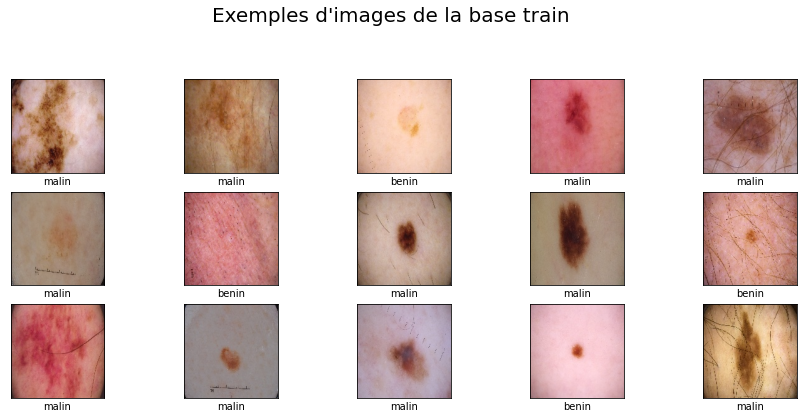

In [73]:
Visualisation.display_examples(class_names, train_images, train_labels) 
# Pour plus de renseignement : help(Visualisation.display_examples)

### 4 - Modèle de CNN

Un réseau de neurones convolutifs est un système composé de neurones, généralement répartis en plusieurs couches connectées entre elles. Nous l'utilisons ici pour résoudre un problème de classification. Le réseau calcule à partir de l'entrée une probabilité pour chaque classe ('bénin' ou 'malin'). 
Chaque couche reçoit en entrée des données et les renvoie transformées. Pour cela, elle calcule une combinaison linéaire puis applique éventuellement une fonction non-linéaire, appelée fonction d'activation. Les coefficients de la combinaison linéaire définissent les paramètres (ou poids) de la couche.
Un réseau de neurones est construit en empilant les couches : la sortie d'une couche correspond à l'entrée de la suivante.
La dernière couche calcule les probabilités finales en utilisant pour fonction d'activation.
Une fonction de perte (loss function) est associée à la couche finale pour calculer l'erreur de classification.

N'ayant pas encore fait de cours de Machine Learning à l'ENSAE, nous nous sommes basées sur les ressources suivantes :    
<li> cours openclassrooms Classez et segmentez des données visuelles : https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles</li>
<li> https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/</li>

Les CNN réalisent eux-mêmes le travail fastidieux d'extraction et de description des features, cela constitue une des forces des réseaux de neurones convolutifs : plus besoin d'implémenter un algorithme d'extraction "à la main", comme SIFT ou Harris-Stephens. 
Comme nous l'avons vu précédemment, un reseau de neurones est constitué de plusieurs couches. Il existe quatre types de couches pour un réseau de neurones convolutif : 
<p>
<li>la couche de convolution,</li> 
<li> la couche de pooling, </li> 
<li> la couche de correction ReLU, </li> 
<li> la couche fully-connected.</li> 
</p>

In [6]:
# Importation des packages de machine learning 
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from tensorflow.keras.layers import (Conv2D, Dense,Dropout, Flatten,MaxPooling2D)
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import models 

Using TensorFlow backend.


#### 1- Premier modèle simple :

##### a) construction du modèle

In [91]:
model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (150, 150, 3)), 
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),  
    
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2), 
    
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2), 
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [92]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Nous ajoutons des "callbacks", cela permet, sous certaines conditions, d'arreter ou de modifier le modéle pendant son entrainement. 

In [93]:
# La condition suivante permet d'arrêter l'entrainement si le modéle n'apprend pas pendant 5 périodes : 
earlystop = EarlyStopping(patience=5) 
# La condition suivante permet d'ajuster le taux d'apprentissage au cours du temps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
# On réunit les deux conditions :
callbacks = [earlystop, learning_rate_reduction]

Voir l'annexe "Explications du modèle" pour plus de détails sur le choix des couches et des paramétres.

##### b) Entrainement

In [94]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2, callbacks=callbacks)

Epoch 1/20
5/5 [==============================] - 8s 2s/step - loss: 0.7159 - accuracy: 0.5063 - val_loss: 0.6895 - val_accuracy: 0.5500
Epoch 2/20
5/5 [==============================] - 8s 2s/step - loss: 0.6945 - accuracy: 0.4938 - val_loss: 0.6888 - val_accuracy: 0.5500
Epoch 3/20
5/5 [==============================] - 9s 2s/step - loss: 0.6878 - accuracy: 0.5469 - val_loss: 0.6889 - val_accuracy: 0.5250
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 0.6797 - accuracy: 0.5766 - val_loss: 0.6804 - val_accuracy: 0.5625
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 0.6861 - accuracy: 0.5437 - val_loss: 0.6878 - val_accuracy: 0.5312
Epoch 6/20
5/5 [==============================] - 9s 2s/step - loss: 0.6926 - accuracy: 0.5094 - val_loss: 0.6760 - val_accuracy: 0.6000
Epoch 7/20
5/5 [==============================] - 9s 2s/step - loss: 0.6807 - accuracy: 0.5719 - val_loss: 0.6952 - val_accuracy: 0.4875
Epoch 8/20
5/5 [=======================

In [95]:
test_loss = model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 82ms/step - loss: 0.5849 - accuracy: 0.7000


Visualisation de la courbe accuracy au cours des époques :

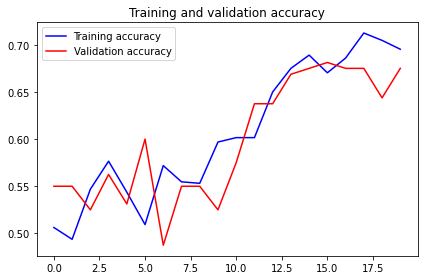

In [96]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.title('Training and validation accuracy')

legend = plt.legend()
plt.tight_layout()
plt.show()

Visualisation de la courbe loss au cours des époques :

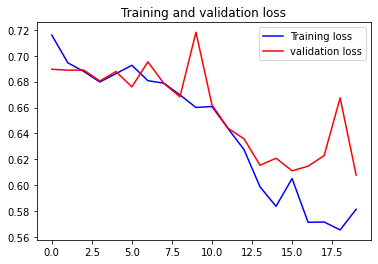

In [97]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')

legend = plt.legend()
plt.show()

##### c) Résultats 

Représentation de la matrice de confusion :

In [98]:
predictions = model.predict(test_images)     
pred_labels = np.argmax(predictions, axis = 1) 

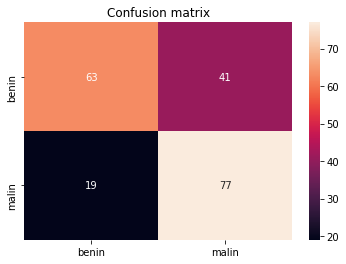

In [99]:
CM = sklearn.metrics.confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [100]:
PredictBenin_Benin = CM[0][0]  
PredictMalin_Benin =CM[0][1] 
PredictBenin_Malin = CM[1][0] 
PredictMalin_Malin = CM[1][1] 

# Sensibilité
TPR = PredictMalin_Malin/(PredictMalin_Malin+PredictBenin_Malin)
print('Sensibilité',TPR)

# Spécificité
TNR = PredictBenin_Benin/(PredictBenin_Benin+PredictMalin_Benin)
print('Specificite',TNR)

# Valeur prédictive positive
VPP = PredictMalin_Malin/(PredictMalin_Malin+PredictMalin_Benin)
print('Valeur prédictive positive :',VPP)

# Valeur prédictive négative
VPN = PredictBenin_Benin/(PredictBenin_Benin+PredictBenin_Malin)
print('Valeur prédictive négative',VPN)

# Taux de faux positifs
TFP = PredictMalin_Benin/(PredictMalin_Benin+PredictMalin_Malin)
print('Taux de faux positifs',TFP)

# Taux de faux négatifs
TFN = PredictBenin_Malin/(PredictBenin_Malin+PredictBenin_Benin)
print('Taux de faux négatifs',TFN)


Sensibilité 0.8020833333333334
Specificite 0.6057692307692307
Valeur prédictive positive : 0.652542372881356
Valeur prédictive négative 0.7682926829268293
Taux de faux positifs 0.3474576271186441
Taux de faux négatifs 0.23170731707317074


L'accuracy (proportion des prédictions correctes effectuées par le modèle), n'est pas un indicateur suffisant pour juger l'efficacité d'un modèle d'un point de vue médical. Certains indicateurs comme par exemple la sensibilité, la spécificité ou les valeurs prédictives positives et négatives sont utilisés pour évaluer les tests diagnostics. 
Etudions certaines de ces statistiques :  

- **Sensibilité et faux négatifs:**

Cette matrice de confusion nous informe que parmi les mélanomes (classe malin), notre modèle prédit 77 mélanomes et 19 grains de beauté bénins. La **sensibilité** d'un test diagnostic est sa capacité à détecter un maximum de mélanomes malins. C'est la probabilité que ce test soit positif (classe malin) sachant que le grain de beauté est malin. Nous aimerions que cette probabilité soit la plus proche possible de 1 pour limiter au maximum les faux négatifs. 

Un test est **faux négatif** s'il indique un résultat négatif (bénin), alors que le fait étudié correspond à un cas positif (malin). Il y a dans ce modèle 23% de faux négatifs.

On trouve une probabilité d'environ 80% pour la sensibilité. Ce qui est assez élevé, cependant pour une maladie mortelle pour 20 à 30% des cas de mélanomes, on pourrait vouloir que ce taux soit plus élévé, et que la probabilité de faux négatifs soit plus faible. Cela constitue **l'erreur de première espèce**, la plus dangereuse, celle à limiter; prédire à un patient que tout va bien alors qu'il a un mélanome.


- **Spécificité et faux positifs:** 

Parmi les grains de beauté (classe bénin), l'algorithme détecte 63 grains de beauté contre 41 mélanomes. La **spécificité** d'un test diagnostic est la probabilité que le test soit négatif (bénin) sachant que l'on se trouve dans une population de bénins.

Cette probabilité est ici d'environ 61%. Le but de la spécificité est d'avoir le moins de **faux positifs** possible. C'est la situation dans laquelle on prédit un mélanome à un patient alors qu'il n'est pas porteur de la maladie. Cette valeur est ici de 35%.
On a donc une valeur de spécificité assez faible, et un taux de faux positifs élévé. Cependant, cela correspond à **l'erreur de second rang** ( la moins dangereuse), il vaut mieux prédire a un patient qu'il a une forte probabilité d'avoir un mélanome alors que ce n'est pas le cas, plutôt que de prédire que c'est un simple grain de beauté alors que c'est un mélanome. 
Cela ne lui coutera qu'un passage chez le dermatologue, qui lui donnera un diagnostic plus adapté à sa situation. Notons cependant que cette erreur, si elle ne représente pas un coût "médical" à proprement parler trop important, a néanmoins un coût émotionnel important pour le patient (qui s'inquiète pour rien) - aussi a-t-elle aussi vocation à être diminuée autant que possible.  


- **Valeurs prédictives positive et négative:**

La **valeur prédictive positive** (VPP) est la probabilité que le grain de beauté soit un mélanome lorsque l'algorithme prédit que c'est un mélanome. D'après notre modèle, quand on prédit "malin", on a alors 65% de 'chance' que ce soit rééllement un mélanome.

La **valeur prédictive négative** (VPN) est la probabilité que ce soit un grain de beauté bénin lorsque l'algorithme prédit un grain de beauté bénin. D'après notre modèle, en prédisant 'bénin', on a 77% de chance que le grain de beauté soit effectivement bénin.

Ces statistiques dépendent de notre population, il faut prendre de la distance avec celles-ci. De plus, notre échantillon "Test" est assez faible, seulement 200 images, ce qui augmente la possibilité de biais de ces probabilités.

Enregistrement du modèle :

In [101]:
models.save_model(model, Path_Projet_Melanomes+'/premier_modele.h5')

In [7]:
# pour utiliser le modèle sans l'avoir fait tourner au préalable :
# il faut copier le fichier "premier_modele.h5" disponible sur Git dans le dossier "Projet_Melanomes"
model = models.load_model(Path_Projet_Melanomes+'/premier_modele.h5', compile = True)

#### 2 - Améliorations du modéle

Nous souhaitons améliorer la performance de notre modèle. Pour celà, nous pouvons modifier plusieurs aspects de notre réseau de neurones : 
- Les couches : nous pouvons en ajouter ou en supprimer. Nos images sont assez complexes (dimension 150 x 150, images de couleurs... ), c'est pourquoi nous avons besoin de plusieurs couches.
- Ajouter des fonctions : 
    - Dropout(p) : Cette fonction permet de limiter le sur-apprentissage en abandonnant avec probabilité p certains neurones. 
    - La fonction BatchNormalization() : elle est utilisée dans de nombreux réseaux de neurones afin d'élever le taux d'apprentissage des modèles en réduisant la sensibilité des réseaux de neurones aux poids de départ. Malgrè plusieurs tentatives, cette fonction n'a pas permis l'amélioration de notre modèle, elle ne sera donc pas ajouter dans la suite de ce rapport.   
- Les hypers paramétres : Beaucoup d'hypers paramétres sont présents dans la création du modéle ; le nombre de filtres, les fonctions d'activation, la taille du vecteur de sortie de la fonction Dense (units), le paramétre p de la fonction Dropout(p), le learning rate... Ces hypers paramétres sont modifiables. Nous allons créer une fonction permettant de tester différents hypers paramétres afin de récupérer les paramétres rendant notre modéle optimal. 
 

In [60]:
# Importation des packages
from hyperopt import hp # pour une première utilisation : pip install hyperopt
import kerastuner as kt # pour une première utilisation :  pip install keras-tuner
hp = kt.HyperParameters()

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Hyperband
from keras.models import load_model
from tensorflow.keras import metrics

In [61]:
# On indique les hypers parametres que nous voulons tester ainsi que les choix possibles : 

# Le nombre de filtres 
filters=hp.Choice('num_filters', [32,64,128,256])

# La taille du vecteur de sortie et la fonction d'activation 
Dense(units=hp.Int('units', 32, 512, step=32), activation=hp.Choice('dense_activation',['relu','tanh','sigmoid']))

# Le learning rate 
hp.Float('learning_rate',min_value=1e-5, max_value=1e-2, sampling='LOG',default=1e-3)

0.001

In [85]:
INPUT_SHAPE = (150,150,3) # Taille des images
NUM_CLASSES = 2 # Nombre de taille

# Création de la classe CNNHyperModel permettant de modifier les parametres souhaités

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add( Conv2D( filters=16, kernel_size=5,activation="relu",input_shape=self.input_shape,))
        model.add(Conv2D(filters=hp.Choice("num_filters_1", values=[32,16], default=32,),activation="relu",kernel_size=3,))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=hp.Float("dropout_1", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        
        model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
        model.add(Conv2D(filters=hp.Choice("num_filters_2", values=[32, 64], default=64,),activation="relu",kernel_size=3,))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=hp.Float("dropout_2", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        
        model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
        model.add(Conv2D(filters=hp.Choice("num_filters_3", values=[64,128], default=128,),activation="relu",kernel_size=3,))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=hp.Float("dropout_3", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        
        model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
        model.add(Conv2D(filters=hp.Choice("num_filters_4", values=[128,256], default=256,),activation="relu",kernel_size=3,))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=hp.Float("dropout_4", min_value=0.0, max_value=0.5, default=0.25, step=0.05,)))
        
        model.add(Flatten())
        model.add(Dense(units=hp.Int("units", min_value=32, max_value=512, step=32, default=128),activation=hp.Choice('dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu',),))
        model.add(Dropout(rate=hp.Float("dropout_5", min_value=0.0, max_value=0.5, default=0.25, step=0.05 )))
        model.add(Dense(self.num_classes, activation="softmax"))

        model.compile(optimizer=keras.optimizers.Adam(hp.Float("learning_rate",min_value=1e-4,max_value=1e-2,sampling="LOG",default=1e-3,)
            ),loss="sparse_categorical_crossentropy",metrics=["accuracy"],)
        return model
    
    
hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)
                 
    

In [86]:
HYPERBAND_MAX_EPOCHS = 40 # Nombre maximum d'époques d'entrainement
MAX_TRIALS = 20 #  Nombre de combinaisons d'hyperparamètres qui seront testées
EXECUTION_PER_TRIAL = 2 # Nombre de modèles construits et ajustés 

Hyperband est une version optimisée de RandomSearch ( fonction qui échantillonne au hasard des combinaisons d'hyperparamètres et les teste) qui utilise l'arrêt anticipé pour accélérer le processus de réglage des hyperparamètres. L'idée principale est d'adapter un grand nombre de modèles pour un petit nombre d'époques et de ne continuer la formation que pour les modèles atteignant la plus grande précision sur l'ensemble de validation. La variable HYPERBAND_MAX_EPOCHS est le nombre maximum d'époques pour lesquelles un modèle peut être entraîné.

In [88]:
HYPERBAND_MAX_EPOCHStuner = Hyperband(hypermodel, max_epochs= HYPERBAND_MAX_EPOCHS, objective = 'val_accuracy', seed = SEED, executions_per_trial=EXECUTION_PER_TRIAL, directory='hyperband', project_name='CNN_melanome')

INFO:tensorflow:Reloading Oracle from existing project hyperband\CNN_melanome\oracle.json
INFO:tensorflow:Reloading Tuner from hyperband\CNN_melanome\tuner0.json


In [89]:
# Récapitulatif des parametres à tester :
tuner.search_space_summary()

Search space summary
Default search space size: 12
num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 16], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_2 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_3 (Choice)
{'default': 128, 'conditions': [], 'values': [64, 128], 'ordered': True}
dropout_3 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_4 (Choice)
{'default': 256, 'conditions': [], 'values': [128, 256], 'ordered': True}
dropout_4 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512

In [32]:
#### ATTENTION A NE PAS RELANCER 
# ou alors en s'exposant au risque d'attendre plus de 10 heures que la cellule ait fini de s'exécuter
# en effet, l'algorithme va tester toutes les combinaisons possibles pour les hypers parametres 

N_EPOCH_SEARCH = 40
tuner.search(train_images, train_labels, epochs = N_EPOCH_SEARCH, validation_split=0.1)

Trial 86 Complete [00h 31m 05s]
val_accuracy: 0.5875000059604645

Best val_accuracy So Far: 0.7749999761581421
Total elapsed time: 10h 58m 18s
INFO:tensorflow:Oracle triggered exit


In [33]:
# Récapitule les résultats obtenues par tuner.search
tuner.results_summary()

# Récupération du meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluation 
loss, accuracy = best_model.evaluate(test_images, test_labels)

Results summary
Results in hyperband\CNN_melanome
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_filters_1: 16
dropout_1: 0.05
num_filters_2: 32
dropout_2: 0.15000000000000002
num_filters_3: 128
dropout_3: 0.2
num_filters_4: 256
dropout_4: 0.15000000000000002
units: 480
dense_activation: tanh
dropout_5: 0.30000000000000004
learning_rate: 0.00011289813322780023
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 5782f67da6d7a96af5b6454a6754dfb3
Score: 0.7749999761581421
Trial summary
Hyperparameters:
num_filters_1: 16
dropout_1: 0.15000000000000002
num_filters_2: 32
dropout_2: 0.05
num_filters_3: 128
dropout_3: 0.35000000000000003
num_filters_4: 128
dropout_4: 0.35000000000000003
units: 320
dense_activation: relu
dropout_5: 0.35000000000000003
learning_rate: 0.0001077121672213119
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: eaf46eef6b0202e5415f6f4e4

In [146]:
# On reconstruit ce modéle à partir les parametres séléctionnés
hyper_model = keras.Sequential([
    layers.Conv2D(16, (5, 5), activation = 'relu', input_shape = (150, 150, 3)),
    layers.Conv2D(16, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.05),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.15),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.Conv2D(256, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.15),
    layers.Conv2D(128, (3, 3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(480, activation='tanh'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

hyper_model.compile(optimizer=optimizers.Adam(0.00011289813322), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [63]:
history = hyper_model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
5/5 [==============================] - 20s 4s/step - loss: 0.6914 - accuracy: 0.5031 - val_loss: 0.6944 - val_accuracy: 0.4500
Epoch 2/20
5/5 [==============================] - 21s 4s/step - loss: 0.6871 - accuracy: 0.5063 - val_loss: 0.6936 - val_accuracy: 0.4500
Epoch 3/20
5/5 [==============================] - 19s 4s/step - loss: 0.6862 - accuracy: 0.5078 - val_loss: 0.6928 - val_accuracy: 0.4563
Epoch 4/20
5/5 [==============================] - 18s 4s/step - loss: 0.6836 - accuracy: 0.5078 - val_loss: 0.6909 - val_accuracy: 0.5250
Epoch 5/20
5/5 [==============================] - 18s 4s/step - loss: 0.6797 - accuracy: 0.5281 - val_loss: 0.6884 - val_accuracy: 0.5500
Epoch 6/20
5/5 [==============================] - 18s 4s/step - loss: 0.6764 - accuracy: 0.5344 - val_loss: 0.6863 - val_accuracy: 0.5437
Epoch 7/20
5/5 [==============================] - 18s 4s/step - loss: 0.6703 - accuracy: 0.5516 - val_loss: 0.6820 - val_accuracy: 0.5813
Epoch 8/20
5/5 [==================

In [64]:
test_loss_hyper_modele = hyper_model.evaluate(test_images, test_labels)

7/7 [==============================] - 1s 129ms/step - loss: 0.6340 - accuracy: 0.6750


In [65]:
models.save_model(hyper_model, Path_Projet_Melanomes+'/hyper_model.h5')

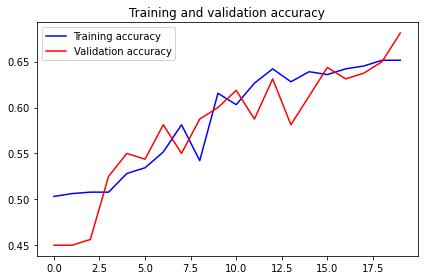

In [66]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.title('Training and validation accuracy')

legend = plt.legend()
plt.tight_layout()
plt.show()

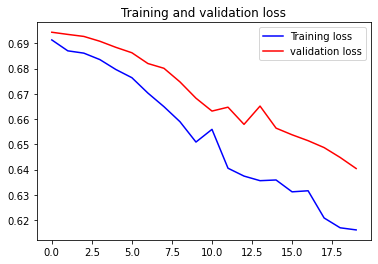

In [67]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')

legend = plt.legend()
plt.show()

**Comparaison :**

In [102]:
print ( 'Notre premier modèle avait une loss de ', round(test_loss[0],2) , 'contre ' , round(test_loss_hyper_modele[0],2), 'pour hyper_model sur la base test',
    "\n"'Le modèle avait une accuracy de ', round(test_loss[1],2) , 'contre ' , round(test_loss_hyper_modele[1],2), 'pour hyper_model sur la base test')

Notre premier modèle avait une loss de  0.58 contre  0.63 pour hyper_model sur la base test 
Le modèle avait une accuracy de  0.7 contre  0.68 pour hyper_model sur la base test


#### 3 - Le modéle amélioré

In [103]:
# Chargement du modèle, pour utiliser le modèle sans l'avoir fait tourner au préalable :
# il faut copier le fichier "premier_modele.h5" disponible sur Git dans le dossier "Projet_Melanomes"
hyper_model = models.load_model(Path_Projet_Melanomes+'/hyper_model.h5', compile = True)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


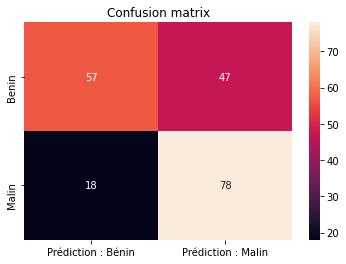

In [104]:
predSimple= hyper_model.predict_classes(test_images)

cm = sklearn.metrics.confusion_matrix(test_labels,predSimple)

ax = plt.axes()

sns.heatmap(cm, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=('Prédiction : Bénin', 'Prédiction : Malin'), 
           yticklabels= ('Benin', 'Malin'), ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [105]:
PredictBenin_Benin = cm[0][0]  
PredictMalin_Benin =cm[0][1] 
PredictBenin_Malin = cm[1][0] 
PredictMalin_Malin = cm[1][1] 

# Sensibilité
TPR = PredictMalin_Malin/(PredictMalin_Malin+PredictBenin_Malin)
print('Sensibilité',TPR)

# Specificite
TNR = PredictBenin_Benin/(PredictBenin_Benin+PredictMalin_Benin)
print('Specificite',TNR)

# Valeur prédictive positive
VPP = PredictMalin_Malin/(PredictMalin_Malin+PredictMalin_Benin)
print('Valeur prédictive positive :',VPP)

# Valeur prédictive négative
VPN = PredictBenin_Benin/(PredictBenin_Benin+PredictBenin_Malin)
print('Valeur prédictive négative',VPN)

# Taux de faux positifs
TFP = PredictMalin_Benin/(PredictMalin_Benin+PredictMalin_Malin)
print('Taux de faux positifs',TFP)

# Taux de faux négatifs
TFN = PredictBenin_Malin/(PredictBenin_Malin+PredictBenin_Benin)
print('Taux de faux négatifs',TFN)


Sensibilité 0.8125
Specificite 0.5480769230769231
Valeur prédictive positive : 0.624
Valeur prédictive négative 0.76
Taux de faux positifs 0.376
Taux de faux négatifs 0.24


- **Sensibilité et faux négatifs:**

La matrice du confusion nous informe que parmi les mélanomes, le modèle a prédit 78 mélanomes et 18 grains de beauté. 

Le taux de **faux négatifs** est de 24%, contre 23% dans notre modèle précédent.

On trouve une probabilité d'environ 81% pour la sensibilité, comme pour le modèle précédent. 

- **Spécificité et faux positifs:** 

Parmi les grains de beauté bénins, l'algorithme détecte 57 grains de beauté bénins contre 47 mélanomes. 

La **spécificité** est d'environ 54%, contre 60% dans le modèle précédent. 

- **Valeur prédictive positive et négative:**

La **valeur prédictive positive** (VPP) est de 62%, contre 65% dans le modèle précédent. 

La **valeur prédictive négative** (VPN) est de 76%, contre 77% dans le modèle précédent. 


**Conclusion** : ce modèle, pourtant construit pour optimiser les différents paramètres, semble moins bon que le premier modèle construit sans optimisation. Un résultat que nous ne saurions expliquer. D'autant qu'en faisant tourner ce modèle sur un kernel Kaggle, nous obtenons de meilleurs résultats (accuracy systématiquement supérieure à 0,7). 

Prédiction d'une image : 

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import (load_img ,img_to_array)

def Predire_une_image(img_path, modele, img_name='', path_Diagnostic =''):
    
    '''
    Cette fonction permet de prédire si l'image placée en pararemetre appartient à la classe des mélanomes bénins ou malins.
    
    Elle prend en parametre :
        - img_path : le chemin vers l'image  (ex : 'C:/Users/Bureau/ISIC_4960802.jpg')
        - img_name : le nom de l'image (ex : 'ISIC_4960802' )
        - modele : le modele choisi pour prédire (ex: 'model.h5')
        - path_Diagnostic : chemin vers fichier comprenant le diagnostic associé à l'image. Ce fichier peut ne pas exister, c'est pourquoi il prend en valeur par défaut 'None'
        
    Elle renvoie : 
        - A quelle classe appartient l'image sélectionnée ainsi que la probabilité d'appartenir à cette classe 
        
    Exemple :
        --> Predire_une_image('../input/test1000/ISIC_4960802.jpg',ISIC_4960802,'model.h5')
        --> Cette image appartient à la classe malin avec probabilité de 99.96951818466187 %
        
    '''    
    # Chargement du modèle 
    model = load_model(modele)
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Chargement de l'image
    img = load_img(img_path, target_size=(150, 150))
    img_tensor = img_to_array(img) 
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor /= 255.

    # Affichage de l'image 
    plt.imshow(img_tensor[0])
    plt.show()
    
    #Quelques statistiques 
    classe = model.predict_classes(img_tensor) # Prédit la classe 0 ou 1 
    proba = model.predict_proba(img_tensor)
    pred = model.predict(img_tensor)
    
    key_list = [k  for (k, val) in class_names_label.items() if val == classe]
    print('Cette image appartient à la classe ', key_list[0], 
          'avec une probabilité de' ,round((100*proba[0][classe[0]]),2),'%' )
    
    # Ajout du diagnostic médical si l'image est associé à un fichier.csv de diagnostics
    if len(path_Diagnostic) > 0 and len(img_name)>0 : 
        df_diag= pd.read_csv(path_Diagnostic) 
        resp = False
        liste = df_diag['image_name'].str.contains(img_name)
        for i in liste :
            if i == True:
                resp=True
        if resp == True:
            classe_diag =int(df_diag.target[df_diag['image_name'] == img_name])
            key_list_diag = [k  for (k, val) in class_names_label.items() if val == classe_diag]
            print('Selon le réel pronostic médical, ce grain de beauté est de type ', key_list_diag[0] ,'.')
        else:
            print("L'image n'appartient pas au fichier Diagnostic")

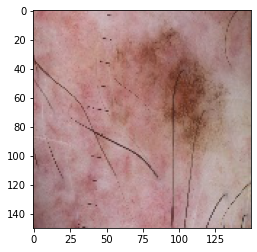

Cette image appartient à la classe  malin avec une probabilité de 57.81 %
Selon le réel pronostic médical, ce grain de beauté est de type  malin .


In [108]:
# On choisit une image aléatoirement dans la base JPG_Sample_Test_Resize :
files = os.listdir(Path_Projet_Melanomes+'/JPG_Sample_Test_Resize')
file = files[random.randint(0, len(files))]
file = file[:-4]

# Chemin vers l'image
path_image = Path_Projet_Melanomes+'/JPG_Sample_Test_Resize/'+file+'.jpg'
# Chemin vers le modele 
model = Path_Projet_Melanomes+'/hyper_model.h5'
#Chemin vers le fichier Diagnostic.csv (facultatif)
path_diagnostic =Path_Projet_Melanomes+'/Diagnostic.csv' # Facultatif 
# Nom de l'image (facultatif): 
img_name = file # ex : 'ISIC_1738297'

Predire_une_image(path_image, model, file, path_diagnostic)

### 5 - Modèle pré-entraîné

Enfin, on essaie d'améliorer la fiabilité de notre prédiction en utilisant un modèle pré-entraîné, à travers le principe du **transfer learning**. Le principe est d'utiliser les connaissances acquises par un réseau de neurones entraîné sur un grand nombre d'images, et d'appliquer ces connaissances à notre problème particulier (la reconnaissance de mélanomes). 

Pour ce faire, nous utiliserons **VGG16** : il s'agit d'un réseau de neurones construit par K. Simonyan et A. Zisserman (univeristé d'Oxford), considéré comme l'un des meilleurs dans le champs de la vision. Comme son nom l'indique, ce CNN est constitué de 16 couches. 

De plus, nous utiliserons des poids pré-établis pour ce CNN sur le dataset **ImageNet** (un jeu de données de plus de 14 millions d'images appartenant à 1 000 classes différentes).


In [111]:
# importation des modules 

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import config

VGG16 prend en entrée des images de taille 224x224, il nous faut donc re-charger nos images (précédemment en taille 150x150) à la bonne taille :

In [112]:
image_size_VGG = 224

In [113]:
path_jpg_train = Path_Projet_Melanomes+'/JPG_Sample_Train' 
path_jpg_test = Path_Projet_Melanomes+'/JPG_Sample_Test' 
    
meta_data = df_sample
meta_data = meta_data.set_index("image_id")
datasets = [path_jpg_train, path_jpg_test]

output_VGG = []

#itération sur chaque dataset (train puis test)
for dataset in datasets :

    files = os.listdir(dataset)
    images = np.zeros((len(files), image_size_VGG, image_size_VGG, 3), dtype=np.float32)
    labels = np.zeros(len(files))

    # itération sur chaque image du dataset
    for i, file in tqdm(enumerate(files)):
        
        # obtention du le chemin de l'image
        img_path = os.path.join(dataset, file)

        # obtention du label de l'image
        label = meta_data.loc[file[0:12]].target

        # ouverture de l'image et retraitement de l'image (changement de couleurs et réduction de taille)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size_VGG, image_size_VGG))

        # ajout de l'image et de son label à la liste de résultats
        images[i, :] = (np.array(image) / 255).astype(np.float32)
        labels[i] = label

        gc.collect()

    output_VGG.append((images, labels))

800it [04:23,  3.03it/s]
200it [01:05,  3.08it/s]


In [114]:
(train_images_VGG, train_labels_VGG), (test_images_VGG, test_labels_VGG) = output_VGG

In [115]:
train_images_VGG, train_labels_VGG = sklearn.utils.shuffle(train_images_VGG, train_labels_VGG, random_state=25)

On construit ensuite le réseau de neurones, à partir de VGG16 et des poids ImageNet

In [116]:
# consutruction du CNN

# les couches de base du CNN sont celles du modèle pré-entraîné, avec les poids issus de ce pré-entraînement (imagenet)
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size_VGG, image_size_VGG, 3))

# on ajoute ensuite quelques couches correspondant plus particulièrement à notre problème 
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='sigmoid'))

# on assemble les deux 
model_VGG = Model(inputs=base_model.input, outputs=add_model(base_model.output))

On compile le modèle 

In [117]:
model_VGG.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),metrics=['accuracy'])

In [118]:
batch_size = 32
epochs = 20

In [119]:
# preprocessing des images : augmentation (pour créer plus d'images artificiellement)
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(train_images_VGG)

In [120]:
config.run_functions_eagerly(True)

In [121]:
# redimensionnage des labels pour qu'ils soient adaptés au modèle VGG
train_labels_VGG = np.asarray(train_labels_VGG).astype('float32').reshape((-1,1))
test_labels_VGG = np.asarray(test_labels_VGG).astype('float32').reshape((-1,1))

On lance finalement l'apprentissage 

In [122]:
# attention  : cette cellule est longue à s'exécutée (environ 2h)
history_VGG = model_VGG.fit(train_images_VGG, train_labels_VGG, batch_size=batch_size, steps_per_epoch=train_images_VGG.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(test_images_VGG, test_labels_VGG),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)])

C:\Users\jeann\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/20
25/25 [==============================] - 698s 28s/step - loss: 0.6868 - accuracy: 0.5688 - val_loss: 0.6837 - val_accuracy: 0.5950
Epoch 2/20
25/25 [==============================] - 755s 30s/step - loss: 0.6646 - accuracy: 0.6300 - val_loss: 0.6893 - val_accuracy: 0.4900
Epoch 3/20
25/25 [==============================] - 708s 28s/step - loss: 0.6192 - accuracy: 0.6662 - val_loss: 0.6063 - val_accuracy: 0.6450
Epoch 4/20
25/25 [==============================] - 661s 26s/step - loss: 0.5746 - accuracy: 0.7075 - val_loss: 0.6064 - val_accuracy: 0.6400
Epoch 5/20
25/25 [==============================] - 644s 26s/step - loss: 0.5506 - accuracy: 0.7113 - val_loss: 0.5521 - val_accuracy: 0.6900
Epoch 6/20
25/25 [==============================] - 638s 26s/step - loss: 0.4916 - accuracy: 0.7563 - val_loss: 0.5386 - val_accuracy: 0.7100
Epoch 7/20
25/25 [==============================] - 652s 26s/step - loss: 0.4700 - accuracy: 0.7700 - val_loss: 0.5224 - val_accuracy: 0.7150
Epoch 

On peut ensutie observer les performances du modèle :

In [125]:
# évolution de la perte et de l'accuracy
hist_as_df = pd.DataFrame(history_VGG.history)
hist_as_df

,loss,accuracy,val_loss,val_accuracy
0,0.686787,0.56875,0.683715,0.595
1,0.664644,0.63000,0.689301,0.490
2,0.619200,0.66625,0.606326,0.645
3,0.574622,0.70750,0.606405,0.640
4,0.550558,0.71125,0.552143,0.690
5,0.491647,0.75625,0.538557,0.710
6,0.470036,0.77000,0.522425,0.715
7,0.442274,0.79125,0.559230,0.725
8,0.528739,0.73750,0.583295,0.650
9,0.420630,0.80250,0.560949,0.715


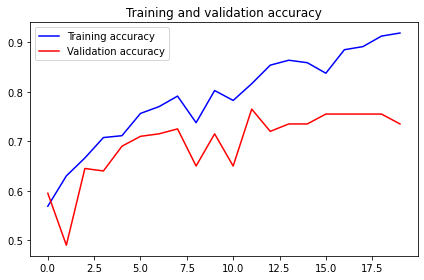

In [126]:
# courbe de l'accuracy au fil des époques
plt.plot(history_VGG.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history_VGG.history['val_accuracy'], color='r',label="Validation accuracy")
plt.title('Training and validation accuracy')

legend = plt.legend()
plt.tight_layout()
plt.show()

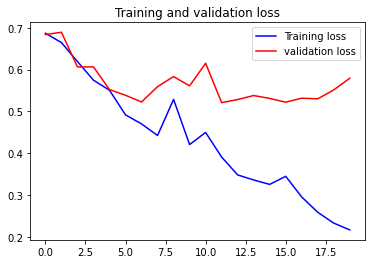

In [127]:
# courbe de la perte au fil des époques 
plt.plot(history_VGG.history['loss'], color='b', label="Training loss")
plt.plot(history_VGG.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')

legend = plt.legend()
plt.show()

La courbe 'validation loss' semble augmenter à partir de la quinzième période, tandis que la 'training loss' continue de diminuer. Cela est potentiellement dû à un sur-apprentissage dans ce modèle. 

In [129]:
# matrice de confusion
predictions = model_VGG.predict(test_images_VGG)     
pred_labels = np.argmax(predictions, axis = 1) 

C:\Users\jeann\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


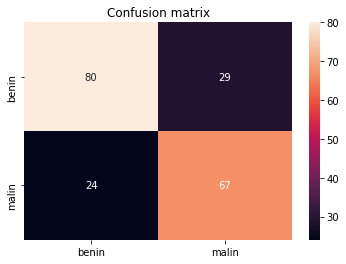

In [130]:
CM = sklearn.metrics.confusion_matrix(pred_labels, test_labels_VGG)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [145]:
PredictBenin_Benin = 80
PredictMalin_Benin = 29
PredictBenin_Malin = 24 
PredictMalin_Malin = 67 

# Sensibilité
TPR = PredictMalin_Malin/(PredictMalin_Malin+PredictBenin_Malin)
print('Sensibilité',TPR)

# Specificite
TNR = PredictBenin_Benin/(PredictBenin_Benin+PredictMalin_Benin)
print('Specificite',TNR)

# Valeur prédictive positive
VPP = PredictMalin_Malin/(PredictMalin_Malin+PredictMalin_Benin)
print('Valeur prédictive positive :',VPP)

# Valeur prédictive négative
VPN = PredictBenin_Benin/(PredictBenin_Benin+PredictBenin_Malin)
print('Valeur prédictive négative',VPN)

# Taux de faux positifs
TFP = PredictMalin_Benin/(PredictMalin_Benin+PredictMalin_Malin)
print('Taux de faux positifs',TFP)

# Taux de faux négatifs
TFN = PredictBenin_Malin/(PredictBenin_Malin+PredictBenin_Benin)
print('Taux de faux négatifs',TFN)


Sensibilité 0.7362637362637363
Specificite 0.7339449541284404
Valeur prédictive positive : 0.6979166666666666
Valeur prédictive négative 0.7692307692307693
Taux de faux positifs 0.3020833333333333
Taux de faux négatifs 0.23076923076923078


- **Sensibilité et faux négatifs:**

La matrice du confusion nous informe que parmi les mélanomes, le modèle en a prédit 67 mélanomes et 24 grains de beauté bénins. 

Le taux de **faux négatifs** est de 23%, comme dans le premier modèle

On trouve une probabilité d'environ 73% pour la sensibilité, contre 81% pour le premier modèle.  

- **Spécificité et faux positifs:** 

Parmi les grains de beauté bénins, l'algorithme détecte 80 grains de beauté bénins contre 29 mélanomes. 

La **spécificité** est d'environ 73%, contre 60% dans le premier modèle. 

- **Valeur prédictive positive et négative:**

La **valeur prédictive positive** (VPP) est de 70%, contre 65% dans le premier modèle. 

La **valeur prédictive négative** (VPN) est de 77%, comme dans le premier modèle.  


**Conclusion** : le modèle pré-entraîné semble meilleur que le premier modèle pour la prédiction de bénins, un peu moins bon pour la prédiction de malins. Une limite de ce modèle cependant : il prend vraiment très longtemps à s'exécuter (l'apprentissage a duré ici plus de 4 heures). 

### 6 - test sur des images hors base

Finalement, pour se rapprocher d'un cas réel d'aide au diagnostic, on essaie de tester notre meilleur algorithme de prédiction (premier_modele) sur une image n'appartenant pas à la base - comme dans un vrai cas de diagnostic, où le patient prend une photo de son grain de beauté. Pour ce faire, on va chercher des images sur internet de grains de beauté malin ou bénin. 

Pour réaliser ces tests, nous utilisons le premier modèle construit, qui nous semble le plus efficace. 

Un cas bénin pour commencer :

In [8]:
import requests

In [9]:
# on télécharge l'image trouvée sur internet
url = "https://cdn.shortpixel.ai/client/q_lossy,ret_img,w_266,h_300/https://www.idoc24.com/wp-content/uploads/2015/07/Dysplastic-nevi1.jpg"
response = requests.get(url, stream=True)

f = Path_Projet_Melanomes

with open(os.path.join(Path_Projet_Melanomes, "benin_test.jpg"), "wb") as f :
        f.write(response.content)  

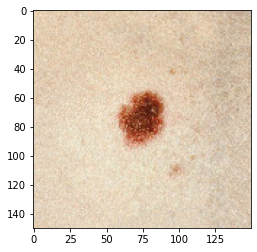

Cette image appartient à la classe  benin avec une probabilité de 60.58 %


In [16]:
# on teste la prédiction
image_path = Path_Projet_Melanomes+"/benin_test.jpg"
model_path = Path_Projet_Melanomes+'/premier_modele.h5'
Predire_une_image(img_path = image_path, modele = model_path)

Avec un mélanome maintenant :

In [34]:
# on télécharge l'image trouvée sur internet
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Melanoma.jpg/260px-Melanoma.jpg"
response = requests.get(url, stream=True)

f = Path_Projet_Melanomes

with open(os.path.join(Path_Projet_Melanomes, "malin_test.jpg"), "wb") as f :
        f.write(response.content)  

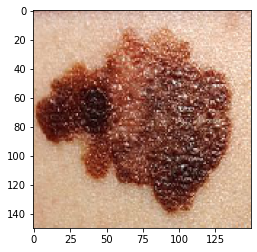

Cette image appartient à la classe  malin avec une probabilité de 84.45 %


In [33]:
# on teste la prédiction
image_path = Path_Projet_Melanomes+"/malin_test.jpg"
model_path = Path_Projet_Melanomes+'/premier_modele.h5'
Predire_une_image(img_path = image_path, modele = model_path)

## Conclusion

### Retour sur la problématique du projet

Notre objectif était d'utiliser la data science pour aider à la reconnaissance des mélanomes. À l'aide d'une base de données d'imagerie médicale constituée spécialement pour ce type de problématique, nous avons ainsi développé un outil d'**aide au diagnostic de mélanomes**. L'utilisation de réseaux de neurones nous a permis de construire un programme posant un diagnostic à partir d'une image de *nævus*. 

Notre perspective n'était pas de construire le programme posant un diagnostic fiable à 100%, comme certains participants au challenge Kaggle sur ce thème ont pu le faire, mais plutôt d'essayer de poser un diagnostic convaincant tout en sachant que nous étions débutantes en machine learning. Nous avons ainsi essayé d'améliorer nos programmes au fur et à mesure, jusqu'à arriver avec ce que nous considérions comme un résultat satisfaisant au regard de nos moyens. 

### Limites de ce projet et développements à poursuivre 

#### a) une aide au diagnostic, et non un remplacement du diagnostic

Du fait même de cet angle d'approche, notre diagnostic final ne saurait prétendre à une fiabilité totale. Notre fonction de diagnostic ne peut pas prédire avec une certitude de 100% si un grain de beauté est un mélanome ou non. C'est pourquoi nous avons préféré donner un diagnostic en termes de **probabilité de malignité**, plutôt qu'une réponse définitive. 

Plutôt que de remplacer le diagnostic d'un médecin, ce programme pourrait donc se concevoir comme une **aide au diagnostic en amont d'une consultation médicale**, en incitant à se faire dépister. En effet, aller chez un dermatologue pour faire inspecter ses grains de beauté peut parfois sembler un peu inutile ; mais si un patient sait que l'un de ses grains de beauté à une haute probabilité d'être malin, alors il sera plus incité à aller le faire contrôler par un médecin pour diagnostiquer un éventuel mélanome. 

En ce sens, nous pourrions envisager de déployer un tel programme à plus large échelle pour le rendre accessible au grand public, sous forme d'une application par exemple. 

#### b) limites techniques

Tout en restant dans cette perspective d'aide au diagnostic, des améliorations techniques pourraient être apportés à ce projet pour améliorer la précision et la fiabilité du diagnostic posé par le programme. 

Le **nombre d'images utilisées** tout d'abord : nous disposions d'une base d'images de taille très importante (plus de 33 000), mais nous n'avons pu en utiliser qu'une petite partie (1 000) pour entraîner notre programme de diagnotic, du fait des capacités limitées de nos ordinateurs personnels. Utiliser la totalité de cette base d'images pourrait améliorer la pertinence du diagnostic. 

Une autre limite de notre projet réside dans la **dimension statique (par opposition à dynamique) du diagnostic**.En effet, le diagnostic posé sur un grain de beauté repose uniquement sur son aspet à un instant t, alors que l'évolution d'un grain de beauté fait partie des principaux indicateur permettant d'identifier la malignité. Une base de données avec des images d'un même grain de beauté à plusieurs dates aurait pu permettre d'intégrer cette dimension temporelle. 

Nous n'avons pas non plus effectué de **pré-traitement des images** avant de les insérer dans nos réseaux de neurones. Plusieurs raisons à cela : tout d'abord, nous n'avons pas pensé nécessaire d'effectuer une **augmentation** des images dans la mesure où cette opération consiste essentiellement à augmenter artificiellement le nombre d'images, or nous n'avions pas de problème de nombre trop faible d'images (au contraire, puisque nous avions encore plus de 30 000 images inexploitées). Ensuite, des raisons médicales : nous aurions pu par exemple passer les images en noir et blanc pour diminuer la complexité de nos réseaux de neurones, mais des couleurs sont un élément majeur permettant d'identifier des mélanomes. Enfin, une question de moyens limités : nos programmes tournaient déjà pendant plusieurs heures pour extraire les images, trouver la combinaison parfaite en termes de paramètres d'images aurait été extrêmement chronophage ; aussi avons-nous décidé de nous concentrer sur les réseaux de neurones en tant que tels du fait de notre temps limité. 

Une autre amélioration que nous aurions pu apporter à ce projet si nous avions eu un horizon temporel infini : diagnostiquer un mélanome en fonction non seulement de son image, mais aussi des **caractéristiques du patient**. Nous avons ici testé les deux sources d'information de manière séparée, et nous sommes concentrées sur les images après avoir vu que les caractéristiques du patient étaient limitées. Cependant, un programme combinant ces deux informations pourrait être plus efficace. 

Enfin, notre algorithme est actuellement incapable de **distinguer une image sortant du contexte** des grains de beauté. Il pourrait être interessant de l'adapter afin qu'il puisse prédire une classe 'autre' s'il évalue que l'image à prédire n'appartient ni à la classe des mélanomes ni à la classe des grains de beauté.


## Annexe


### Explication du modèle

**La couche de convolution** constitue toujours au moins la première couche d'un CNN.Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. La couche de convolution reçoit donc en entrée plusieurs images, et calcule la convolution de chacune d'entre elles avec chaque filtre. Les filtres correspondent exactement aux caractéristiques que l'on souhaite retrouver dans les images. 


*tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)*

   
<p>
<li> Conv2D : pour les images, Conv1D: dimension 1, Conv3D: pour les volumes </li> 
<li> Filters (32) : Nombre de filtres a apprendre : commencer par un nombre de filtre assez faible (32) et augmenter dans les couches suivantes dans l'idéal des multiples de 2, on peut apprendre dans les premières couches 32, 64, 128 filtres puis aller jusqu'à 256, 512, 1024 dans les couches plus pronfondes. </li> 
<li> kernel_size (5,5) : dimension du kernel, si on a des images jusqu'à 128x128 on va utiliser 3x3. Au dessus on utilisera 5x5 ou 7x7. Il faudra dans les couches suivantes se reduire à du 3x3. </li> 
<li> strides : pas avec lequel on va analyser l'image pixel par pixel. La valeur par défaut est (1, 1); cependant, on peut parfois l'augmenter à (2, 2) pour aider à réduire la taille du volume de sortie.  </li> 
<li> Padding : Il peut prendre deux paramétres "valid" ou "same". Avec le paramètre valide, le volume d'entrée n'est pas rempli de zéro et les dimensions spatiales peuvent être réduites via l'application naturelle de la convolution. On preferera reduire les dimensions spaciales avec la couche de max pooling. On notera padding = 'same' pour la majorité de nos couches. </li> 
<li> data_format: Height, Width, Depth </li>
<li> dilation_rate : On utilise ce parametre de dilatation quand on travaille avec des images de plus haute résolution (où les détails sont importants) ou quand on construit un réseau avec moins de paramètres. </li>
<li> activation : Nom de la fonction d'activation que l'on souhaite appliquer après avoir effectué la convolution. Elle constitue la couche d'activation. On utilisera ici la fonction 'relu' qui est très utilisée dans les CNN. Elle permet un apprentissage plus rapide de notre modéle.  </li>
<li> use_bias : Contrôle si un vecteur de biais est ajouté à la couche de convolution. Recommandé de garder le biais sauf dans des cas particuliers.</li>
<li> kernel_initializer :contrôle la méthode d'initialisation utilisée pour initialiser toutes les valeurs avant d'entraîner réellement le réseau. Recommandé de ne pas y toucher sauf si réseau très profond</li>
<li> bias_initializer : contrôle la façon dont le vecteur de biais est initialisé avant le début de l'entraînement. Recommandé de ne pas y toucher</li>
<li> kernel_regularizer, bias_regularizer, activity_regularizer : controle le type de regularisation. Recommandé de ne pas changer les valeurs par défaut.  </li>
<li> kernel_constraint,  bias_constraint : Ces paramètres permettent d'imposer des contraintes sur la couche Conv2D (ex : non-négativité, la normalisation d'unité et la normalisation min-max ... ). Il est recommandé de laisser les valeur par defaut.</li>
</p>

**La couche de pooling :** Cette couche est souvent placé entre deux couches de convolution : elle reçoit en entrée plusieurs caractéristiques, et applique à chacune d'entre elles l'opération de pooling. L'opération de pooling consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes. La couche de pooling permet de réduire le nombre de paramètres et de calculs dans le réseau. On améliore ainsi l'efficacité du réseau et on évite le sur-apprentissage.


*tf.keras.layers.MaxPooling2D ( pool_size=(2, 2), strides=None, padding="valid", data_format=None)*

<p>
<li> pool_size : facteur de réduction d'échelle (vertical, horizontal). (2, 2) réduira de moitié l'entrée dans les deux dimensions spatiales.</li>
    <li> Strides,  Padding et data_format ont la même signification que dans la couche de convolution. S'ils ne sont pas précisés dans la fonction de MaxPooling2D, ils prendont les mêmes valeurs que dans la couche de convolution. </li>
</p>

**La couche de correction :** 

La couche de correction ReLU remplace toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation. Elle est appliquée dans la couche de convolution de notre modèle :  activation = 'relu'. La fonction 'relu' est très utilisée dans les CNN. Elle permet un apprentissage plus rapide de notre modéle.

Ces deux commandes sont les mêmes :

 - model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3))
 
 - model.add(layers.Conv2D(32, (3, 3), input_shape = (150, 150, 3))       
 model.add(layers.Activation(activations.relu)) </li>


**La couche fully-connected**

La couche fully-connected constitue toujours la dernière couche d'un réseau de neurones, convolutif ou non – elle n'est donc pas caractéristique d'un CNN. 
Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
La dernière couche fully-connected permet de classifier l'image en entrée du réseau : ici elle renvoie un vecteur de taille 2 ( pour une classification binaire). Chaque élément du vecteur indique la probabilité pour l'image en entrée d'appartenir à une classe (malin ou bénin). 

La fonction flatten : Elle permet de convertir des matrices 3D en vecteur 1D.

La fonciton Dense :     
*tf.keras.layers.Dense( units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)*
<p>
    <li> Units :Entier positif précisant la taille du vecteur en sortie</li>
    <li> Activation : indique si une correction ReLU ou softmax est effectuée juste après la couche fully-connected </li>
    <li> Les autres paramétres ont la même description que dans la couche de convolution </li>
</p>

**Compilation du modéle :**

Avant d’entraîner notre modèle, nous devons configurer le processus d’apprentissage en appelant la méthode compile() de Keras.

*compile( optimizer, loss = None, metrics = None, loss_weights = None, sample_weight_mode = None, weighted_metrics = None, target_tensors = None )*

<p>
    <li>optimizer : optimise les poids d'entrée en comparant la fonction de prédiction et de perte. Keras fournit plusieurs optimiseurs sous forme de module. Pour un probleme de classification binaire on utilisera 'adam'</li>

<li>loss : Il s’agit de la fonction de coût que le modèle va utiliser pour minimiser les erreurs. On utilisera loss='sparse_categorical_crossentropy' pour une classification binaire,</li>

<li> metrics : En machine learning, les métriques sont utilisées pour évaluer les performances du modèle. Il est similaire à la fonction de perte, mais n'est pas utilisé dans le processus de formation. Keras fournit plusieurs métriques sous forme de module. Dans le cas d'un probleme de classification on utilise metrics = ['accuracy']</li>

<li> loss_weights, sample_weight_mode, weighted_metrics, target_tensors : Parametres de pondération facultatifs. Nous garderons ces parametres à leur valeur par défaut.   </li>

## Sources :

- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_eco_regressions_lineaires.html
- https://blogs.infinitesquare.com/posts/divers/classifier-des-images-avec-tensorflow
- https://www.kongakura.fr/article?id=OpenCV_Python_Tutoriel
- https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification
- https://python.sdv.univ-paris-diderot.fr/14_creation_modules/
- https://www.youtube.com/watch?v=5K9MtmQjlYk
- https://medium.com/octavian-ai/which-optimizer-and-learning-rate-should-i-use-for-deep-learning-5acb418f9b2
- https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner
- https://analyticsindiamag.com/hands-on-guide-to-implement-batch-normalization-in-deep-learning-models/
- http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_Tensorflow_Keras_Python.pdf
- https://www.kaggle.com/kkhandekar/image-classification-for-beginners-cnn-keras
- https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98